In [2]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt


dataframe = pl.read_parquet("/run/media/mak/Heim/2024/20240826_week8/metashape/20241029_products_uav_data/output/extract/polygon_df/plot_8.parquet")
dataframe



shape: (19_258_665, 23)
┌────────────┬──────────┬──────────┬──────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ Xw         ┆ Yw       ┆ band1    ┆ band2    ┆ … ┆ ycam       ┆ sunelev   ┆ saa       ┆ path      │
│ ---        ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---        ┆ ---       ┆ ---       ┆ ---       │
│ f64        ┆ f64      ┆ f32      ┆ f32      ┆   ┆ f32        ┆ f32       ┆ f32       ┆ str       │
╞════════════╪══════════╪══════════╪══════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 563626.104 ┆ 5.7130e6 ┆ 0.015855 ┆ 0.045515 ┆ … ┆ 5.713036e6 ┆ 64.077271 ┆ 181.26986 ┆ IMG_0197_ │
│ 767        ┆          ┆          ┆          ┆   ┆            ┆           ┆ 7         ┆ 6.tif     │
│ 563626.112 ┆ 5.7130e6 ┆ 0.021579 ┆ 0.063627 ┆ … ┆ 5.713036e6 ┆ 64.077271 ┆ 181.26986 ┆ IMG_0197_ │
│ 019        ┆          ┆          ┆          ┆   ┆            ┆           ┆ 7         ┆ 6.tif     │
│ 563626.119 ┆ 5.7130e6 ┆ 0.029257 ┆ 0.089474 ┆ … ┆ 5.713036e6 ┆ 64.077271 ┆ 181.26986 ┆ IMG_0197_ │
│ 27         ┆          ┆          ┆          ┆   ┆            ┆           ┆ 7         ┆ 6.tif     │
│ 563626.126 ┆ 5.7130e6 ┆ 0.038768 ┆ 0.118516 ┆ … ┆ 5.713036e6 ┆ 64.077271 ┆ 181.26986 ┆ IMG_0197_ │
│ 521        ┆          ┆          ┆          ┆   ┆            ┆           ┆ 7         ┆ 6.tif     │
│ 563626.133 ┆ 5.7130e6 ┆ 0.047851 ┆ 0.142683 ┆ … ┆ 5.713036e6 ┆ 64.077271 ┆ 181.26986 ┆ IMG_0197_ │
│ 773        ┆          ┆          ┆          ┆   ┆            ┆           ┆ 7         ┆ 6.tif     │
│ …          ┆ …        ┆ …        ┆ …        ┆ … ┆ …          ┆ …         ┆ …         ┆ …         │
│ 563633.206 ┆ 5.7130e6 ┆ NaN      ┆ NaN      ┆ … ┆ 5.713052e6 ┆ 43.427704 ┆ 208.47375 ┆ IMG_0009_ │
│ 895        ┆          ┆          ┆          ┆   ┆            ┆           ┆ 5         ┆ 6.tif     │
│ 563633.214 ┆ 5.7130e6 ┆ NaN      ┆ NaN      ┆ … ┆ 5.713052e6 ┆ 43.427704 ┆ 208.47375 ┆ IMG_0009_ │
│ 146        ┆          ┆          ┆          ┆   ┆            ┆           ┆ 5         ┆ 6.tif     │
│ 563633.221 ┆ 5.7130e6 ┆ NaN      ┆ NaN      ┆ … ┆ 5.713052e6 ┆ 43.427704 ┆ 208.47375 ┆ IMG_0009_ │
│ 398        ┆          ┆          ┆          ┆   ┆            ┆           ┆ 5         ┆ 6.tif     │
│ 563633.228 ┆ 5.7130e6 ┆ NaN      ┆ NaN      ┆ … ┆ 5.713052e6 ┆ 43.427704 ┆ 208.47375 ┆ IMG_0009_ │
│ 649        ┆          ┆          ┆          ┆   ┆            ┆           ┆ 5         ┆ 6.tif     │
│ 563633.235 ┆ 5.7130e6 ┆ NaN      ┆ NaN      ┆ … ┆ 5.713052e6 ┆ 43.427704 ┆ 208.47375 ┆ IMG_0009_ │
│ 9          ┆          ┆          ┆          ┆   ┆            ┆           ┆ 5         ┆ 6.tif     │
└────────────┴──────────┴──────────┴──────────┴───┴────────────┴───────────┴───────────┴───────────┘

In [3]:
from typing import List, Tuple, Optional
import logging
from scipy.ndimage import gaussian_filter1d


def _kde1d_fast(
    v: np.ndarray,
    x_grid: np.ndarray,
    bw: float | None = None,
    bins: int = 1024,
    vmin: float | None = None,
    vmax: float | None = None,
) -> np.ndarray:
    """
    Approximate 1D KDE efficiently via histogram + Gaussian smoothing.

    Steps:
    1) Bin values into a fine histogram.
    2) Smooth counts with gaussian_filter1d using sigma derived from bandwidth.
    3) Interpolate smoothed density to x_grid and normalize to integrate to ~1.

    Args:
        v: 1D array of finite samples.
        x_grid: Points where the PDF should be evaluated.
        bw: Bandwidth in data units. If None, use Scott's rule.
        bins: Number of histogram bins for the smoothing grid.
        vmin, vmax: Optional clipping range. If None, inferred from data.

    Returns:
        y_pdf evaluated at x_grid (approximately normalized).
    """
    v = v[np.isfinite(v)]
    if v.size < 5:
        return np.zeros_like(x_grid)

    # Range and histogram grid
    lo = np.min(v) if vmin is None else float(vmin)
    hi = np.max(v) if vmax is None else float(vmax)
    if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
        lo, hi = float(np.nanmin(v)), float(np.nanmax(v))
        if not np.isfinite(lo) or not np.isfinite(hi) or hi <= lo:
            return np.zeros_like(x_grid)

    edges = np.linspace(lo, hi, bins + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])
    counts, _ = np.histogram(v, bins=edges)

    # Bandwidth: Scott's rule if not provided
    if bw is None:
        s = np.std(v)
        n = v.size
        # Scott's rule: bw = 1.06 * s * n^(-1/5); fallback if s==0
        bw = 1.06 * (s if s > 0 else (hi - lo) / 6.0) * (n ** (-1.0 / 5.0))
        if bw <= 0 or not np.isfinite(bw):
            bw = max((hi - lo) / 100.0, 1e-12)

    # Convert bandwidth to sigma in bins
    bin_width = centers[1] - centers[0]
    sigma_bins = max(bw / bin_width, 1e-6)

    # Smooth counts
    smooth = gaussian_filter1d(counts.astype(float), sigma=sigma_bins, mode="nearest")

    # Convert to density (divide by N and bin width)
    density_centers = smooth / (v.size * bin_width)

    # Interpolate to requested x_grid
    y_pdf = np.interp(x_grid, centers, density_centers, left=0.0, right=0.0)

    # Normalize lightly to ensure area ≈ 1 over [lo, hi]
    area = np.trapezoid(y_pdf, x_grid)
    if area > 0 and np.isfinite(area):
        y_pdf = y_pdf / area

    return y_pdf

def angle_kde_plot(
    df,
    band: str,
    bins: Tuple[int, int],
    angle: str,
    xlim: Optional[Tuple[float, float]],
    points: int,
    linewidth: float,
    colors: Optional[List[str]],
    dpi: int,
    ) -> None:
    try:
        df = df.drop_nulls().drop_nans()
        if xlim is not None:
            x_min, x_max = xlim
        else:
            x_min = df.select(pl.col(band).quantile(0.01)).item()
            x_max = df.select(pl.col(band).quantile(0.98)).item()
            print(x_min, x_max)
        x_grid = np.linspace(x_min, x_max, int(points))
        fig_k, ax_k = plt.subplots(figsize=(10, 6), dpi=dpi)

        cycle = colors or plt.rcParams["axes.prop_cycle"].by_key().get("color", None)

        i = 0
        for bin in bins:

            filtered_df = df.filter(
                pl.col(angle)>bin[0],
                pl.col(angle)<bin[1],
            )

            v = filtered_df[band].to_numpy()
            # Restrict to finite values within [x_min, x_max] to match chart limits
            v = v[np.isfinite(v)]
            v = v[(v >= x_min) & (v <= x_max)]
            if v.size < 5:
                continue

            # Fast KDE via histogram smoothing (orders of magnitude faster than gaussian_kde on big data)
            y_pdf = _kde1d_fast(
                v,
                x_grid,
                bw=None,  # or set a float bandwidth in data units (e.g., 0.01)
                bins=5128,  # can lower to 512 for even faster
                vmin=x_min,
                vmax=x_max,
            )

            color = None
            if cycle and i < len(cycle):
                color = cycle[i]
            ax_k.plot(x_grid, y_pdf, label=f"{bin[0]},{bin[1]}", linewidth=linewidth, color=color)
            i+=1

        ax_k.set_xlim(x_min, x_max)
        ax_k.set_ylim(bottom=0.0)
        ax_k.set_xlabel("Reflectance")
        ax_k.set_ylabel("Density (KDE)")
        ax_k.set_title(f"{band} value distributions(KDE) by different {angle} bins ")
        ax_k.grid(True, alpha=0.3)
        ax_k.legend(ncol=2)
        fig_k.tight_layout()
        fig_k.show()
    except Exception as e:
        logging.error(f"[plotting_raster] Failed to create band KDE chart: {e}")



0.0028277095407247543 0.08164452016353607


/tmp/ipykernel_44825/1111078562.py:140: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_k.show()


0.010450415313243866 0.19510677456855774
0.004672456998378038 0.11847195029258728
0.03452929109334946 0.3790273070335388
0.11176793277263641 0.7234895825386047


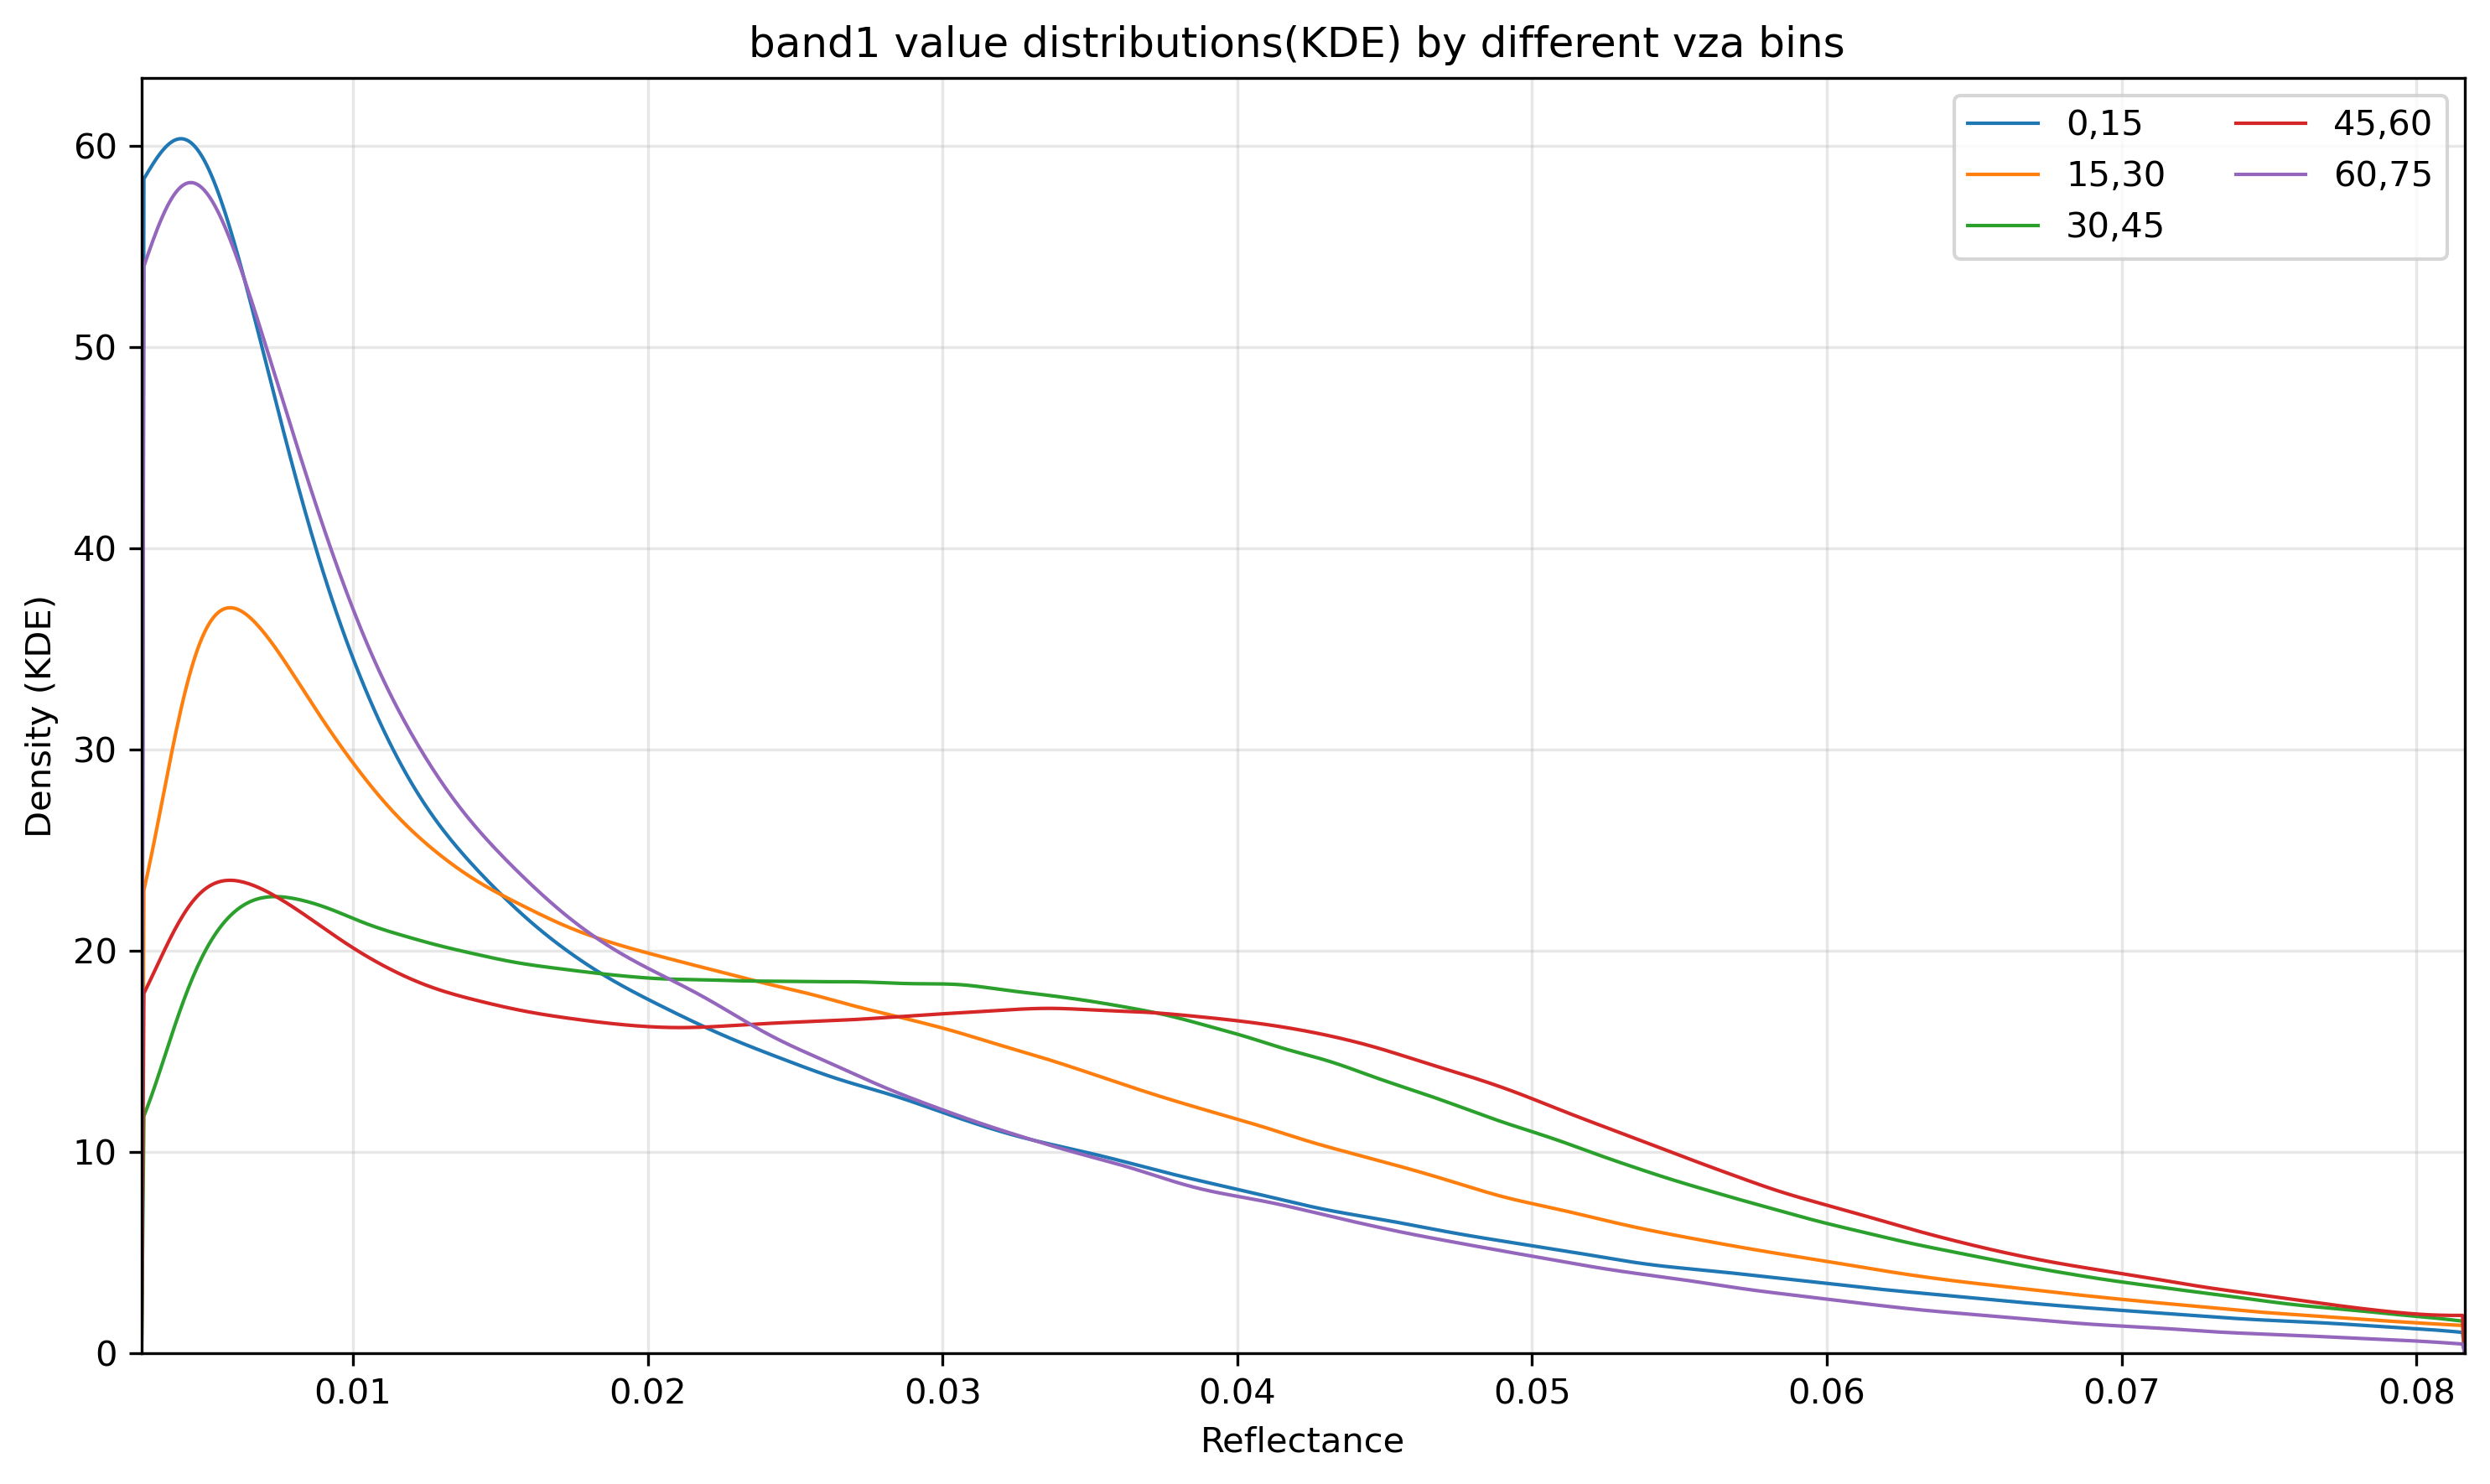

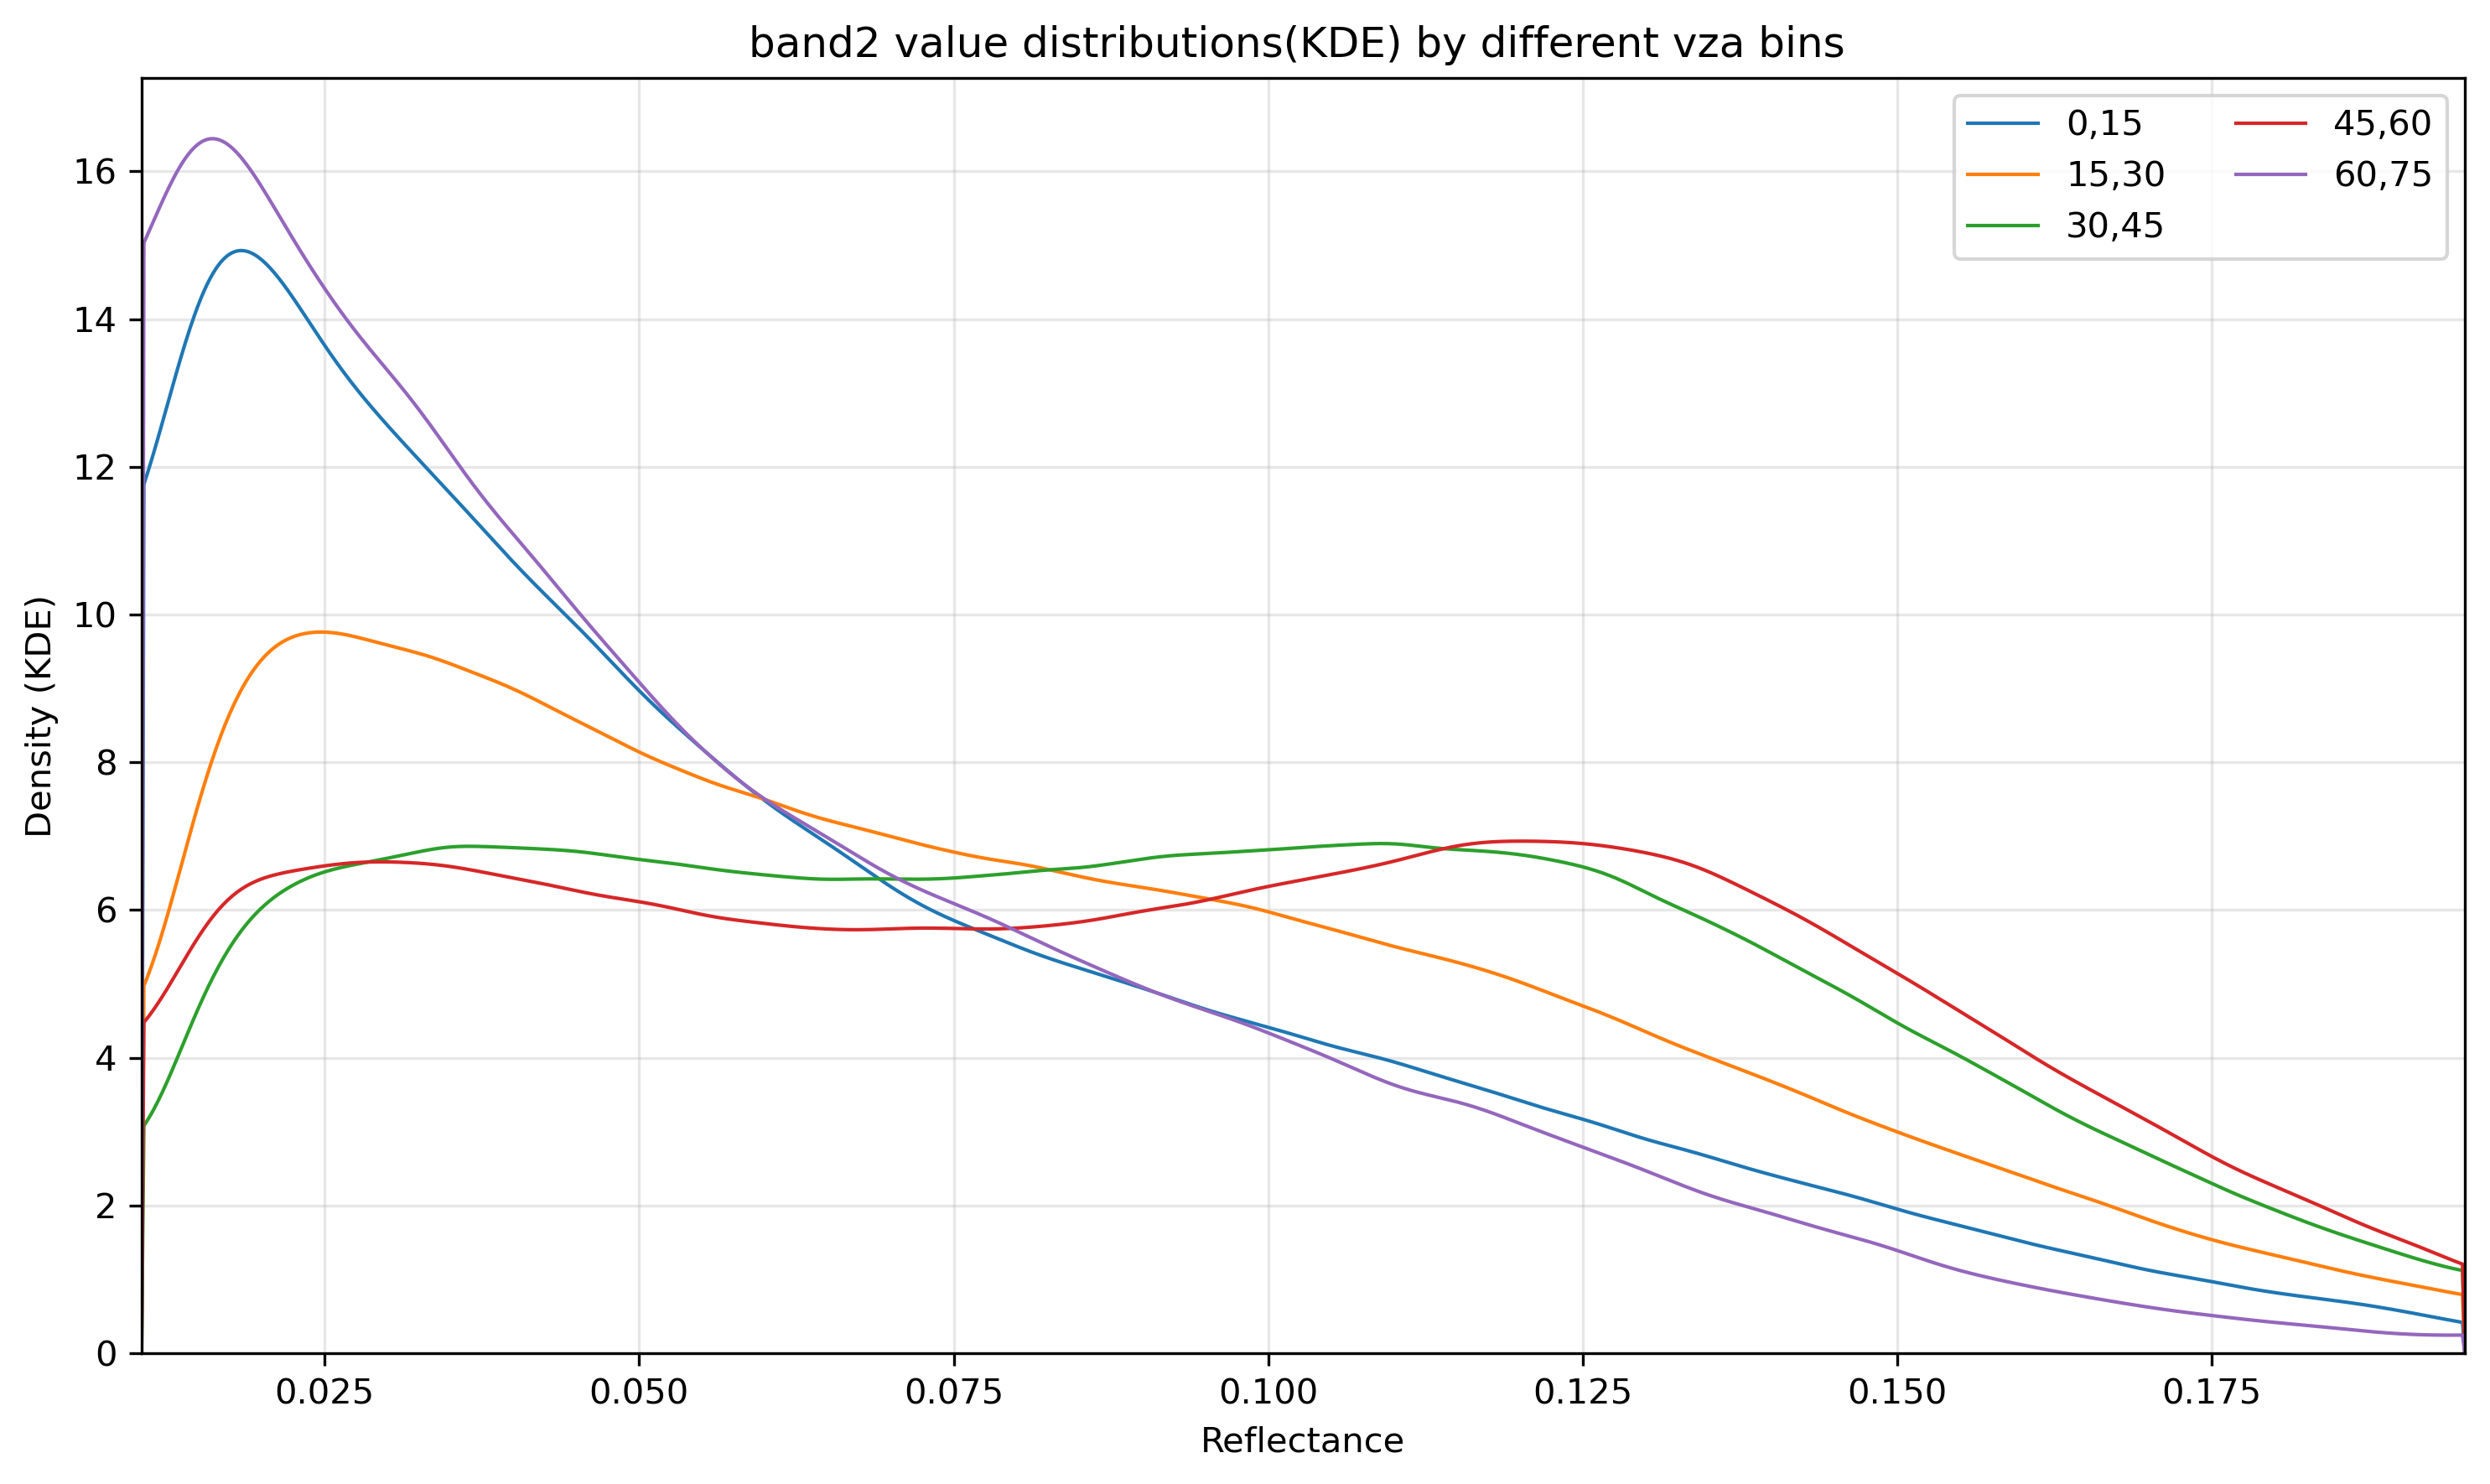

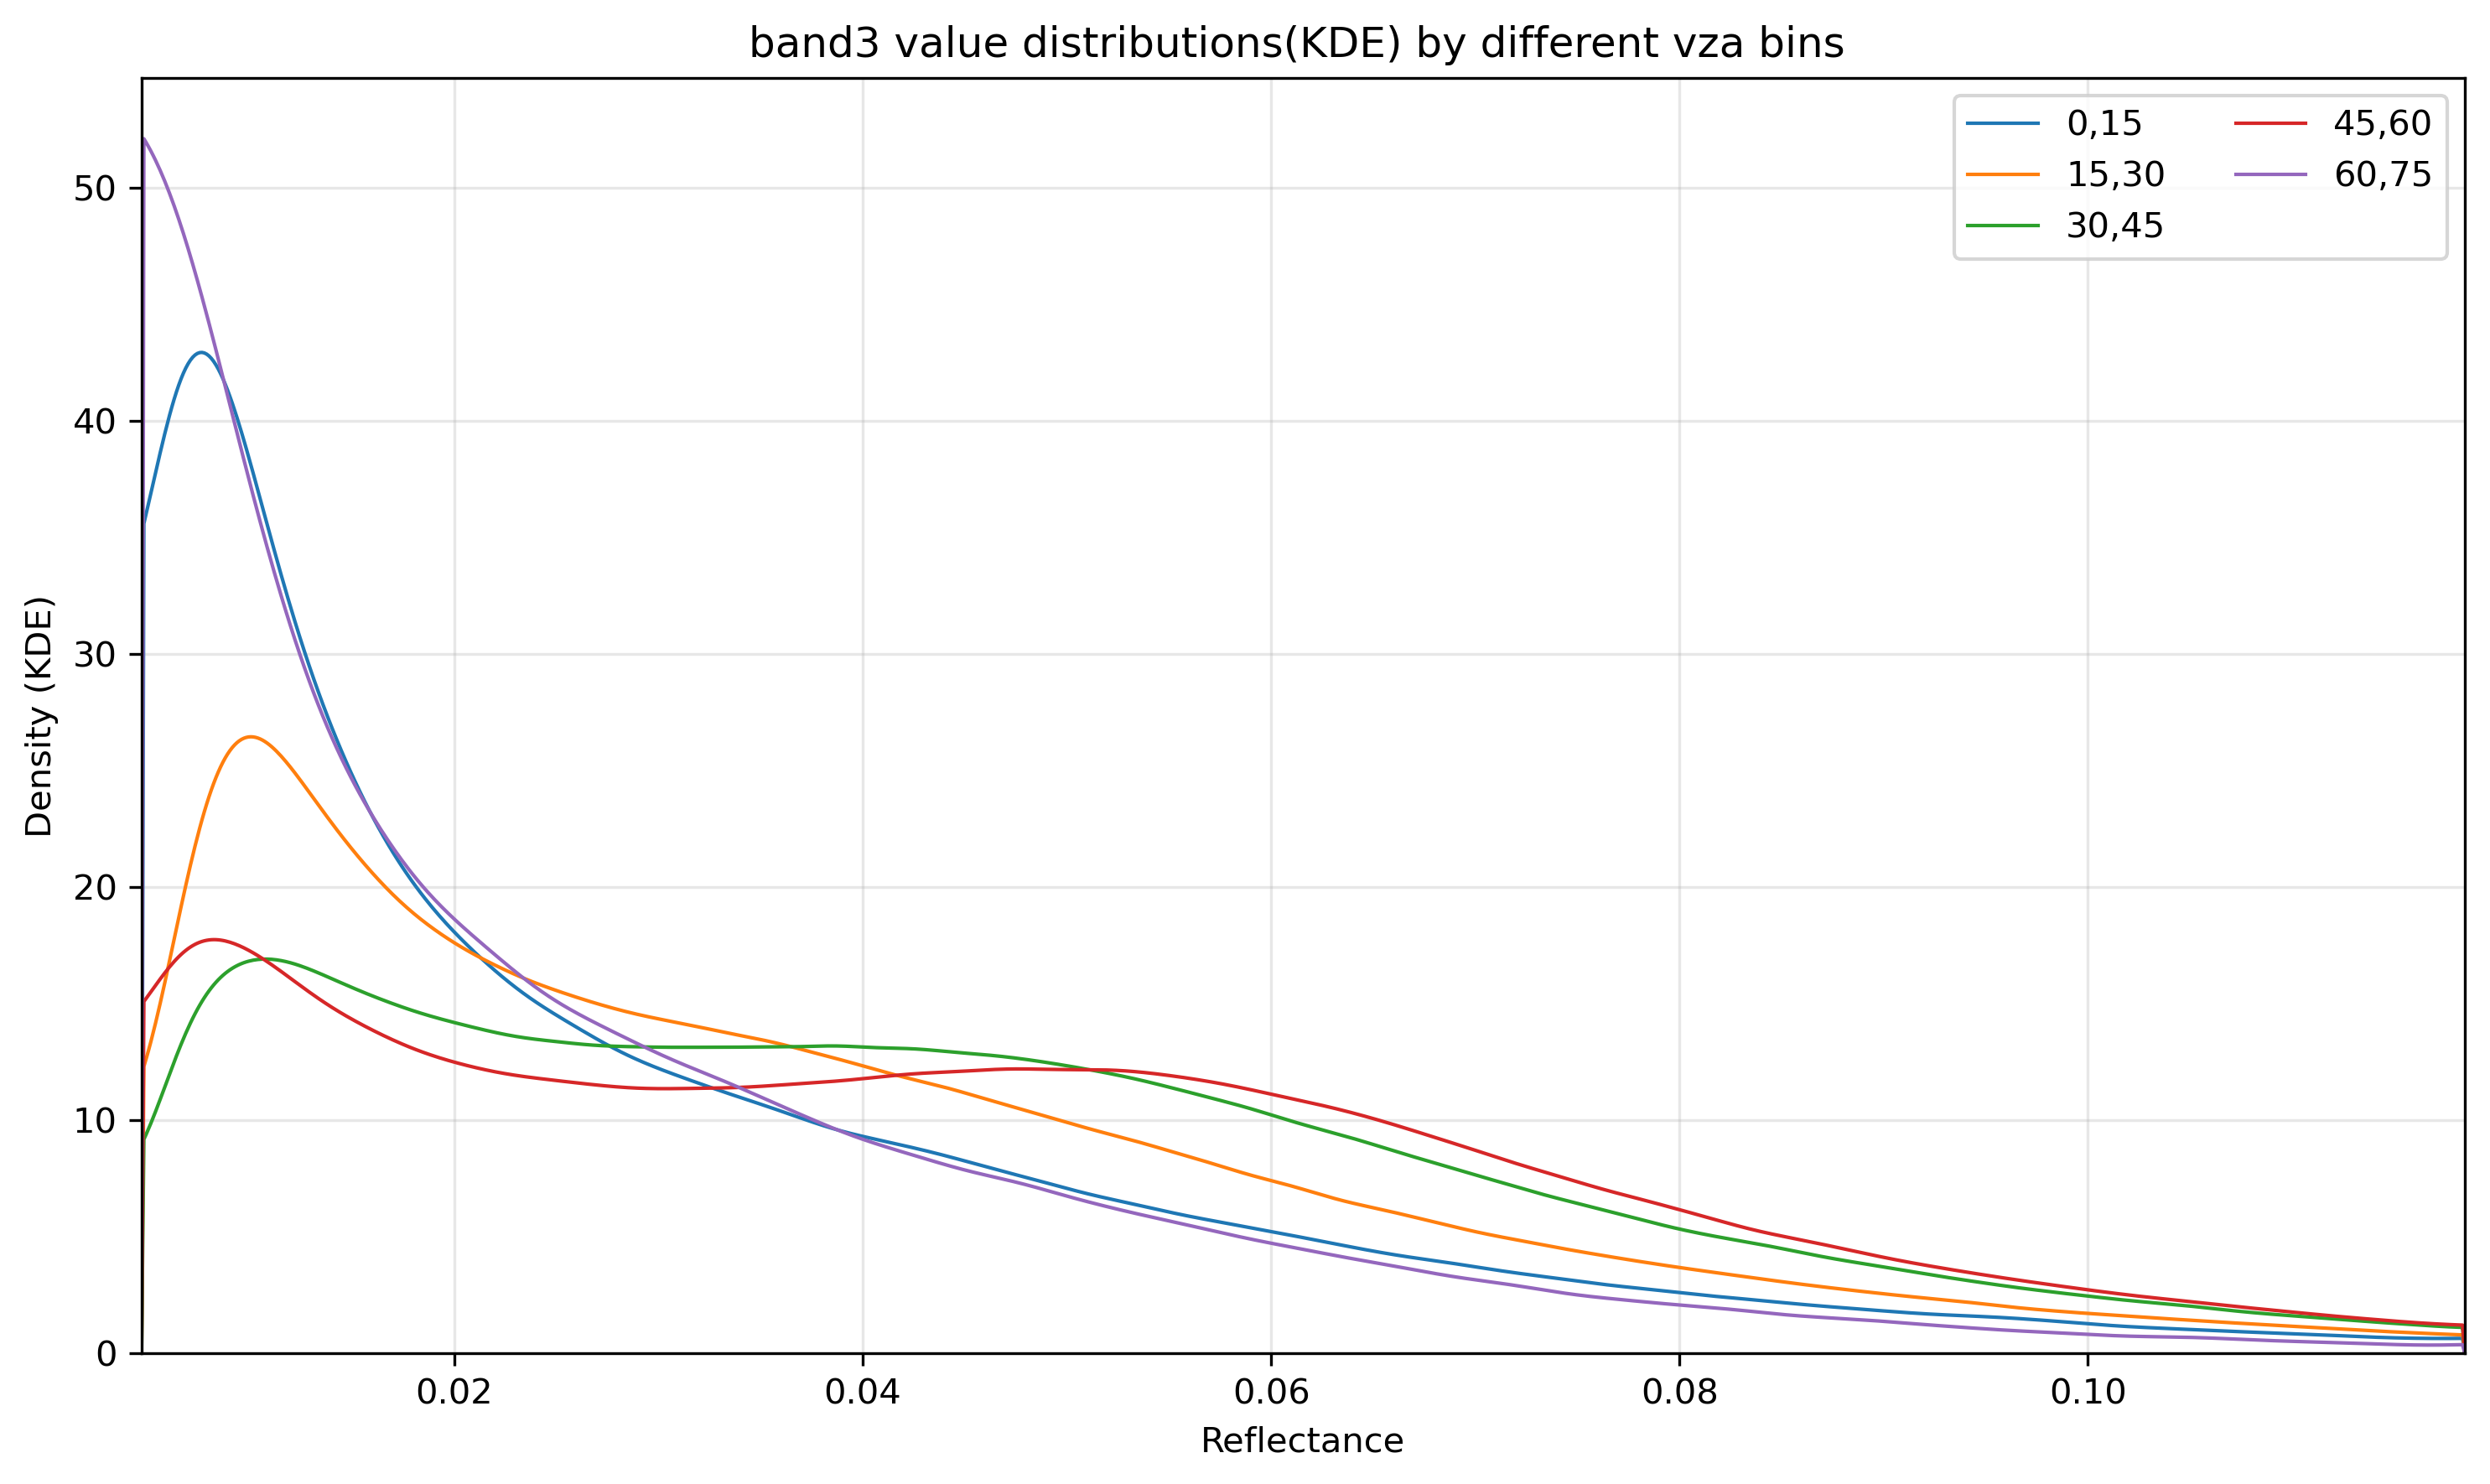

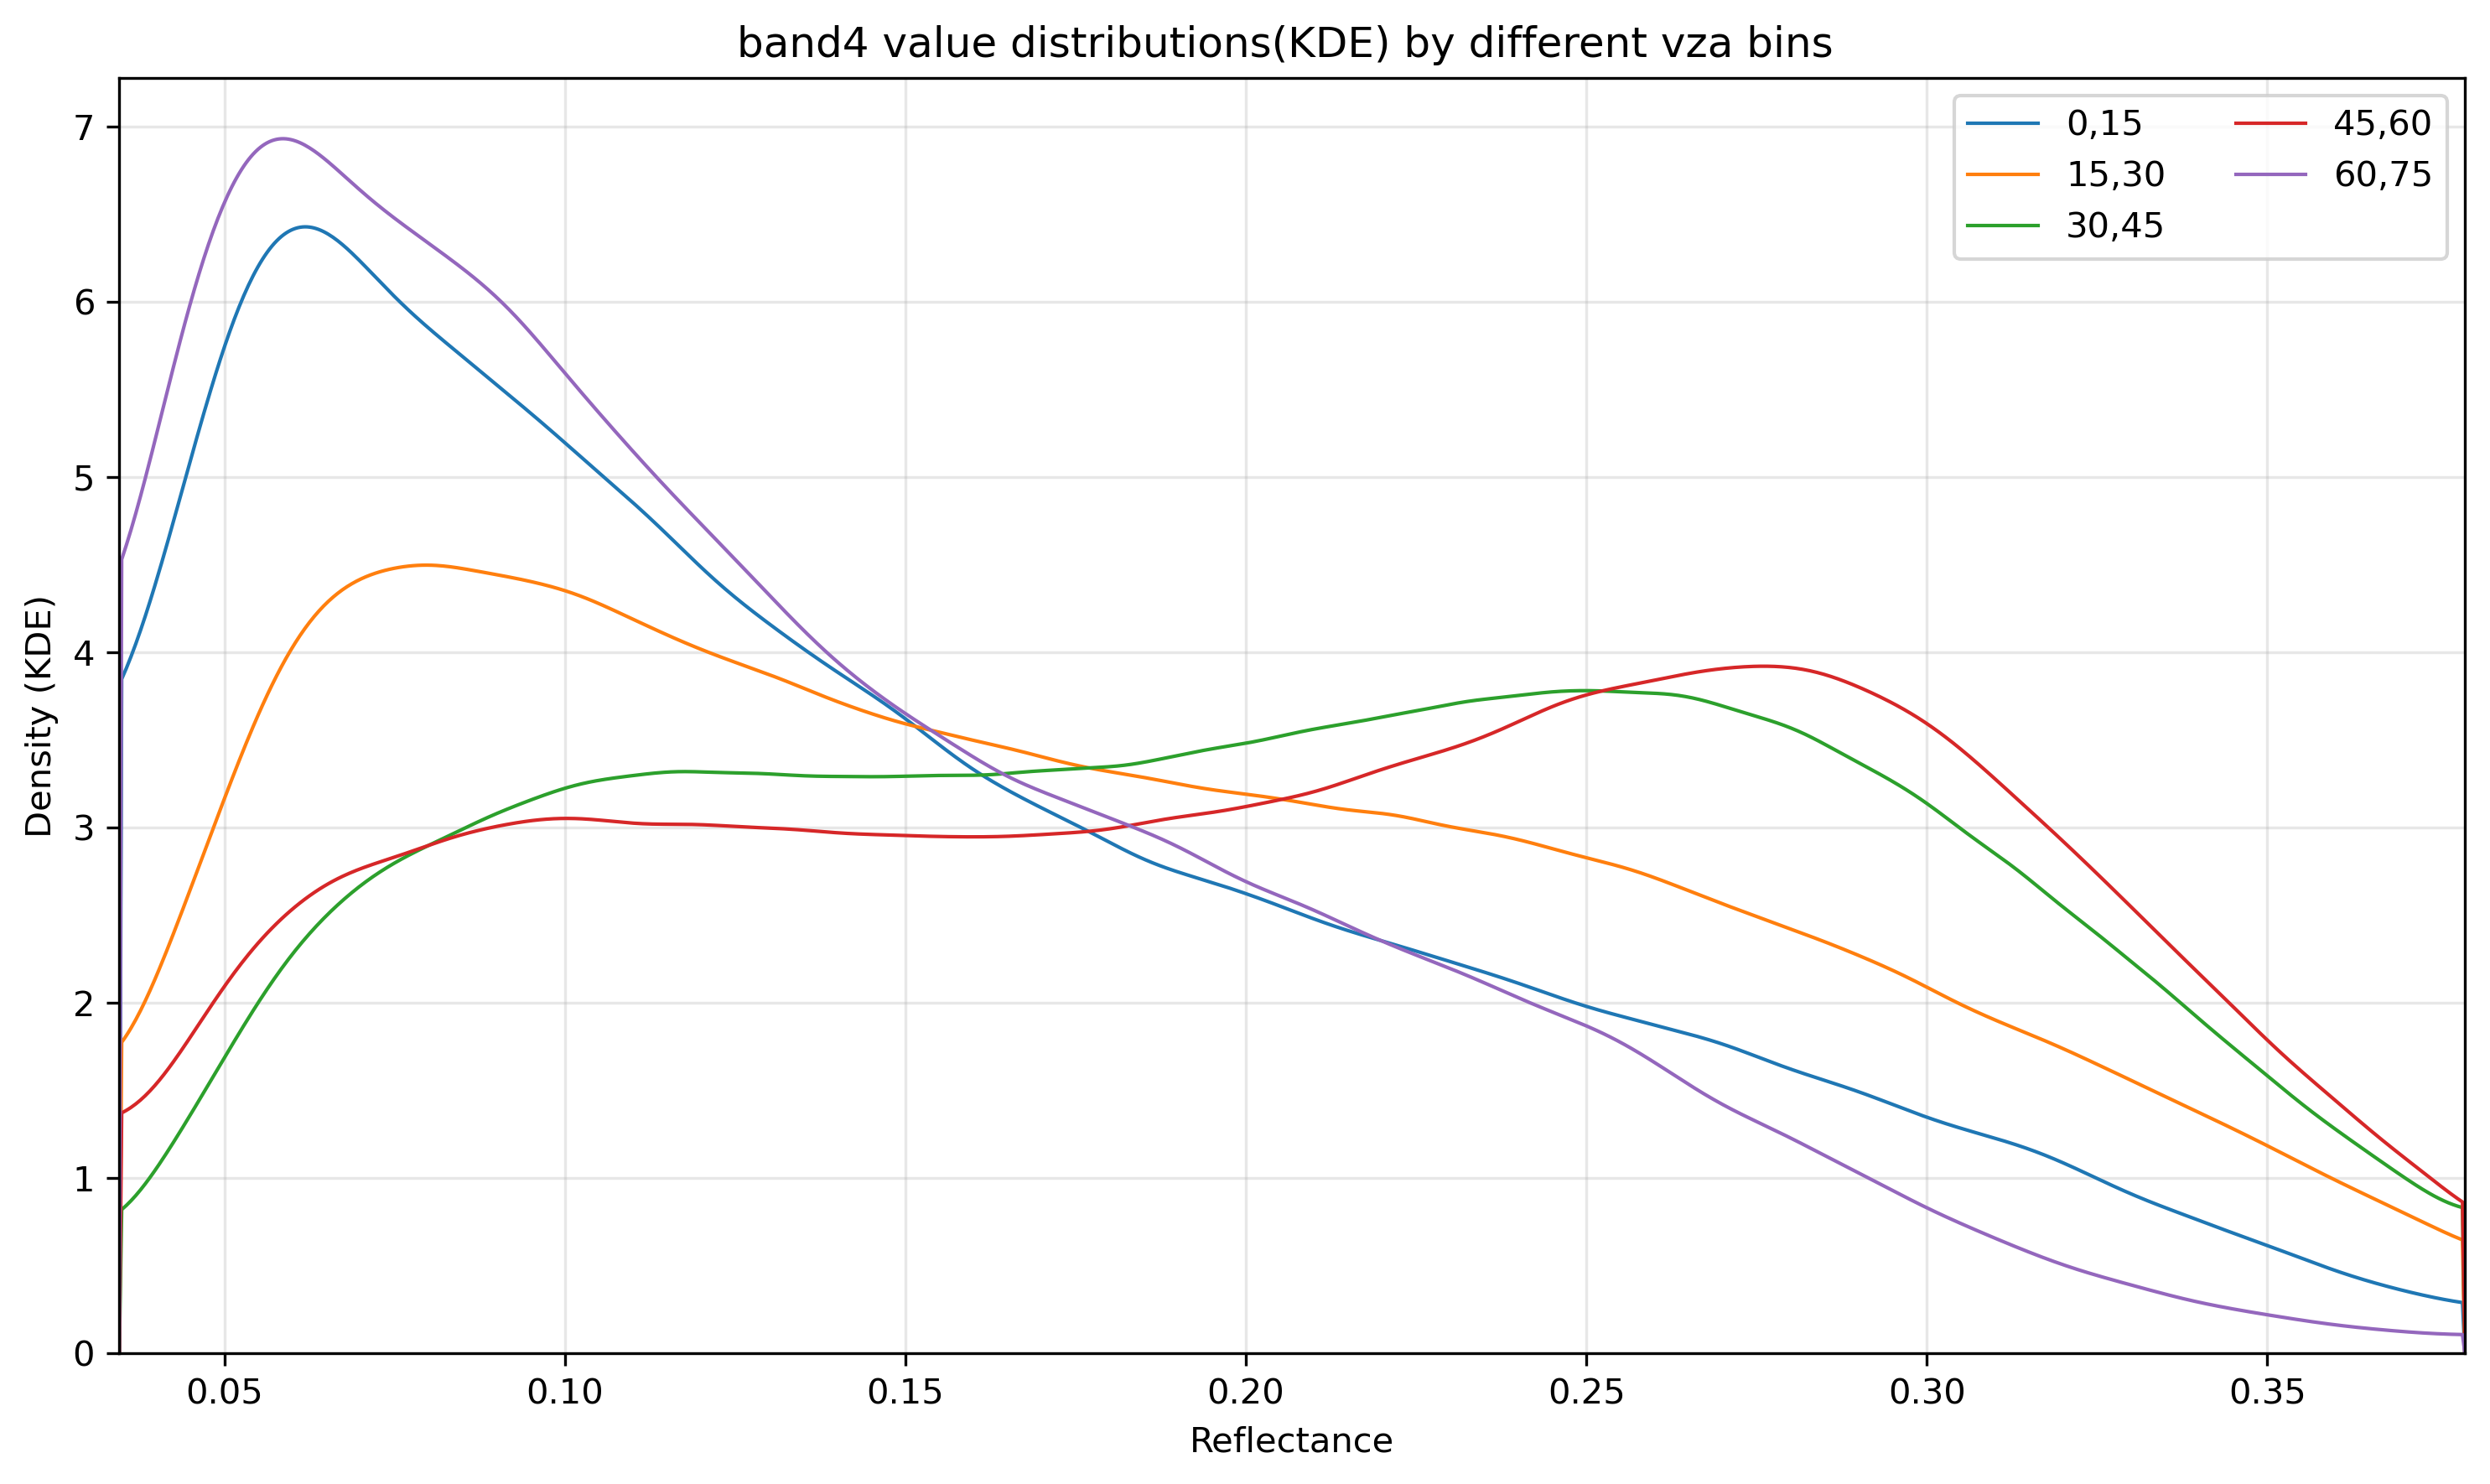

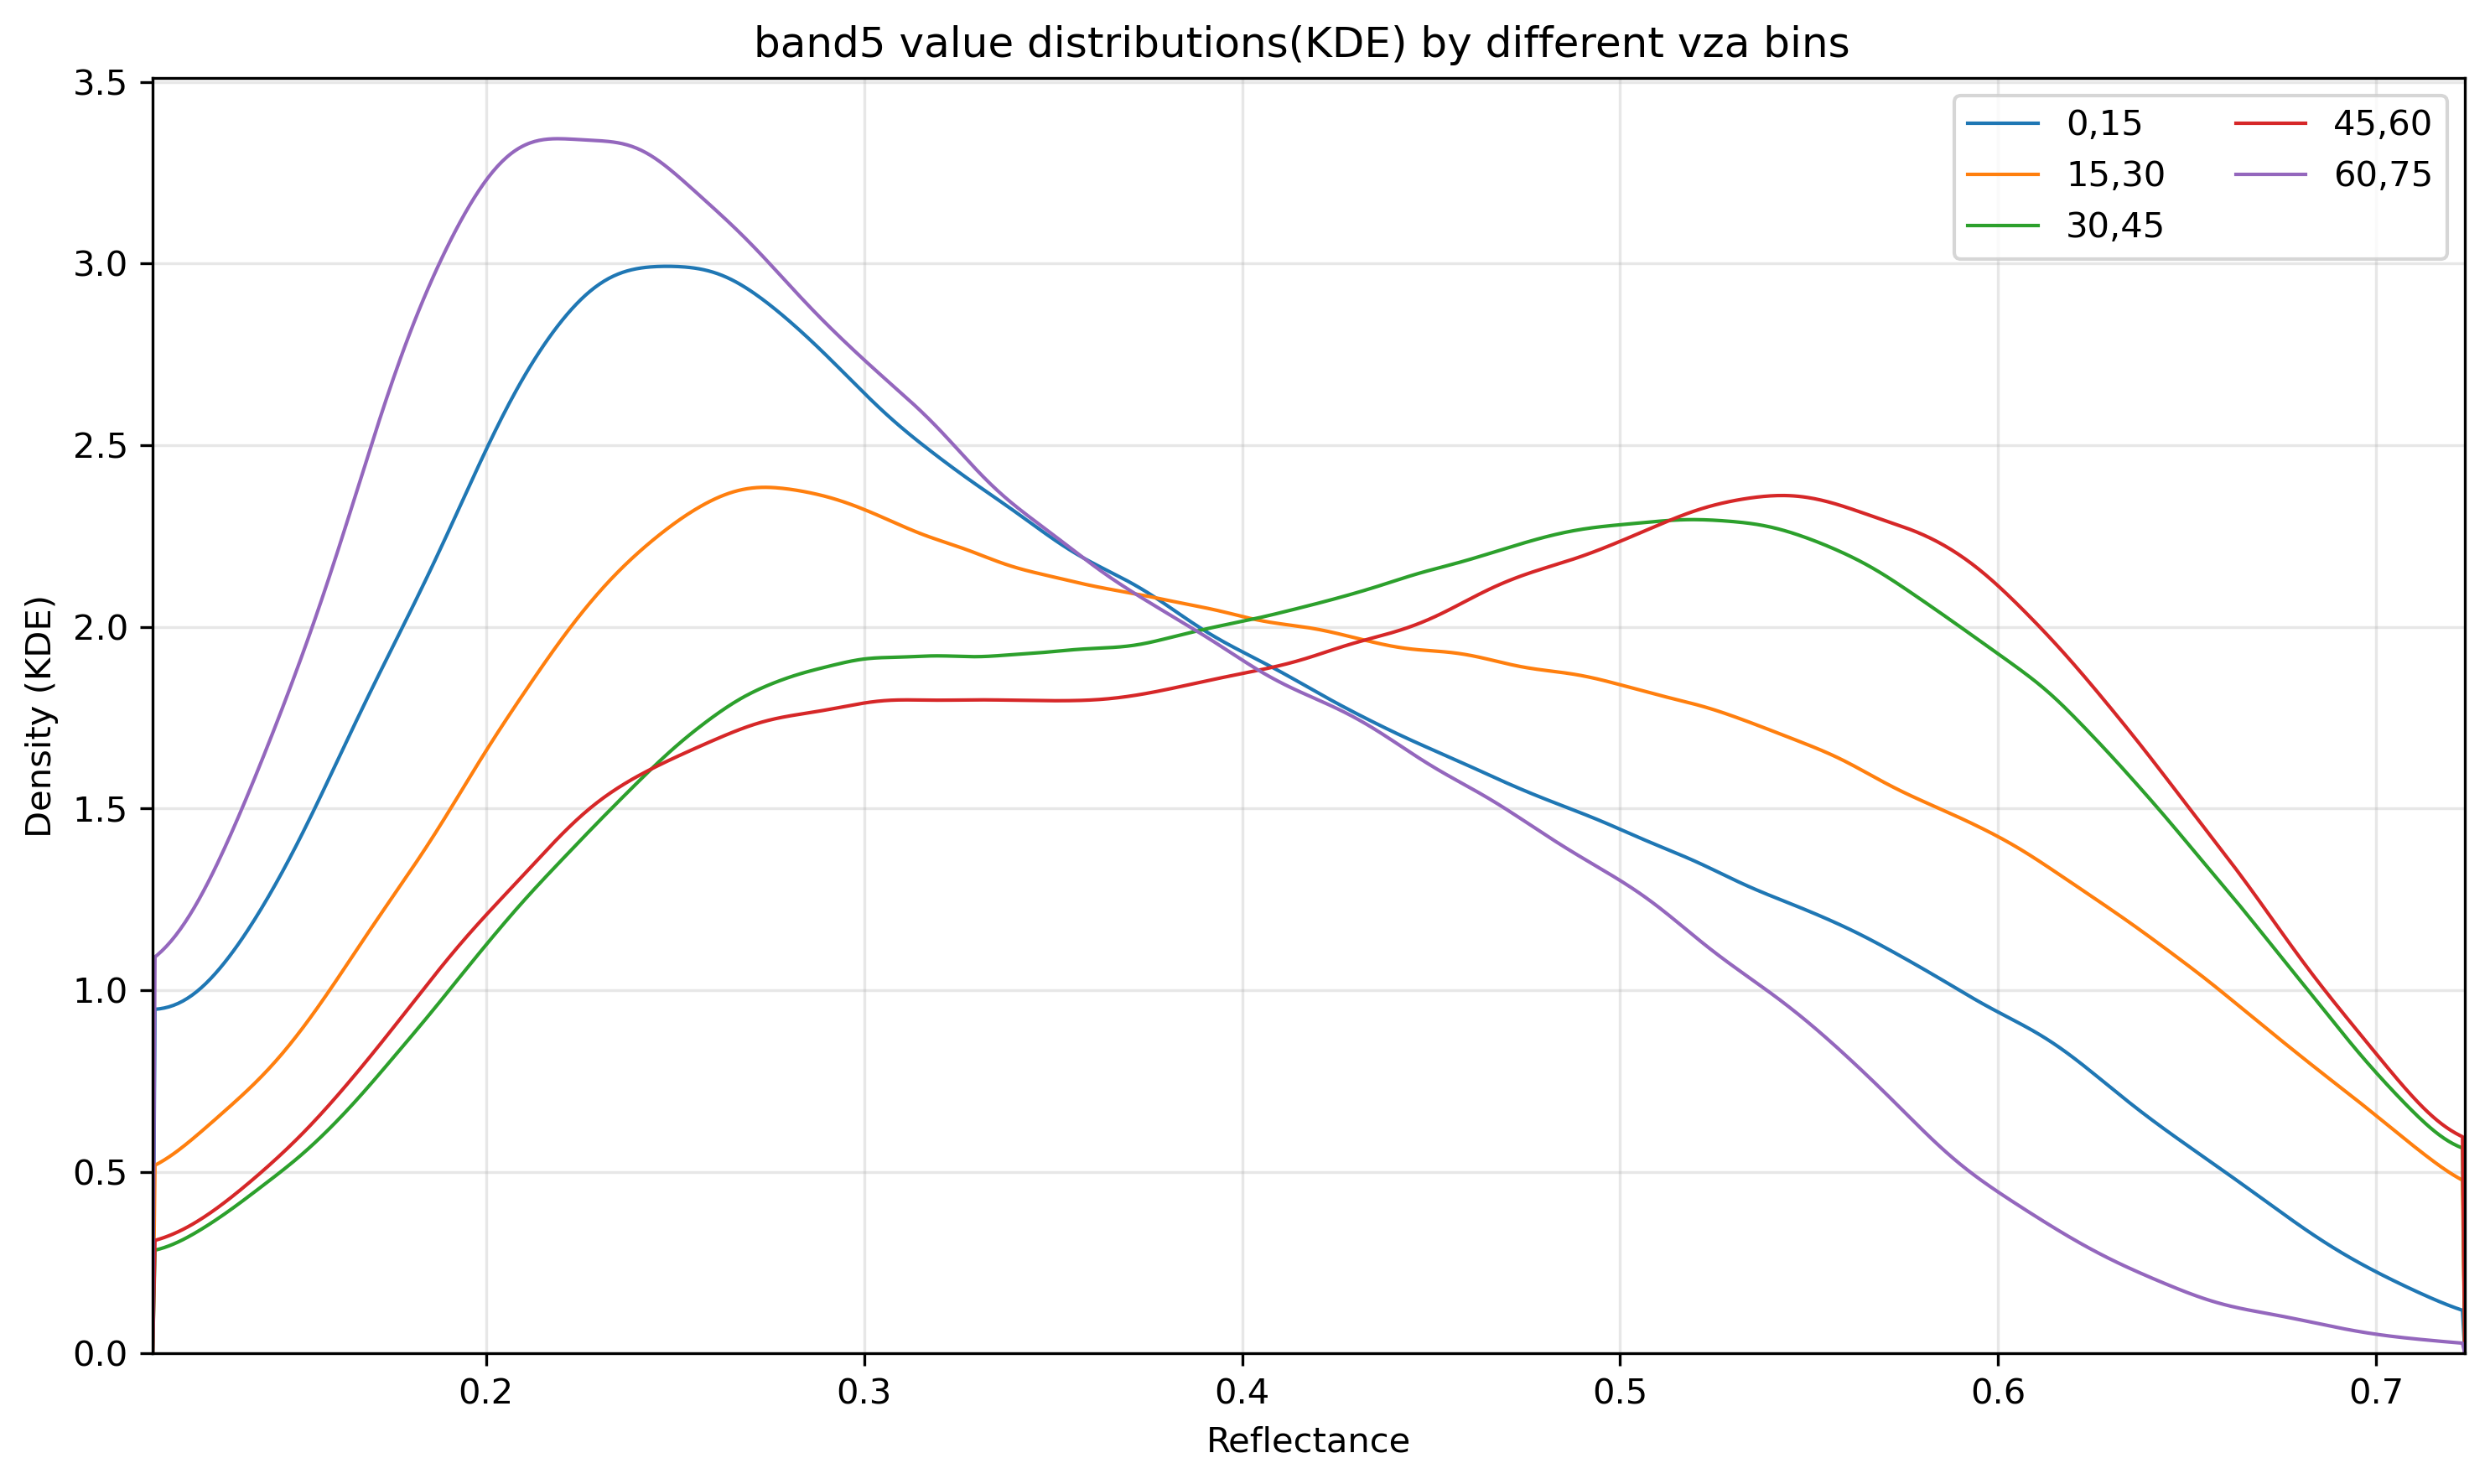

In [4]:
vza_bins = [(0,15),(15,30),(30,45),(45,60),(60,75)]

for band in [f"band{i}" for i in range(1,6)]:
    angle_kde_plot(dataframe, band=band, bins=vza_bins, points=1000, linewidth=1, colors=None, dpi=300, xlim=None, angle='vza')

[(0, 45), (45, 90), (90, 135), (135, 180), (180, 225), (225, 270), (270, 315), (315, 360)]
0.0028277095407247543 0.08164452016353607


/tmp/ipykernel_44825/1111078562.py:140: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_k.show()


0.010450415313243866 0.19510677456855774
0.004672456998378038 0.11847195029258728
0.03452929109334946 0.3790273070335388
0.11176793277263641 0.7234895825386047


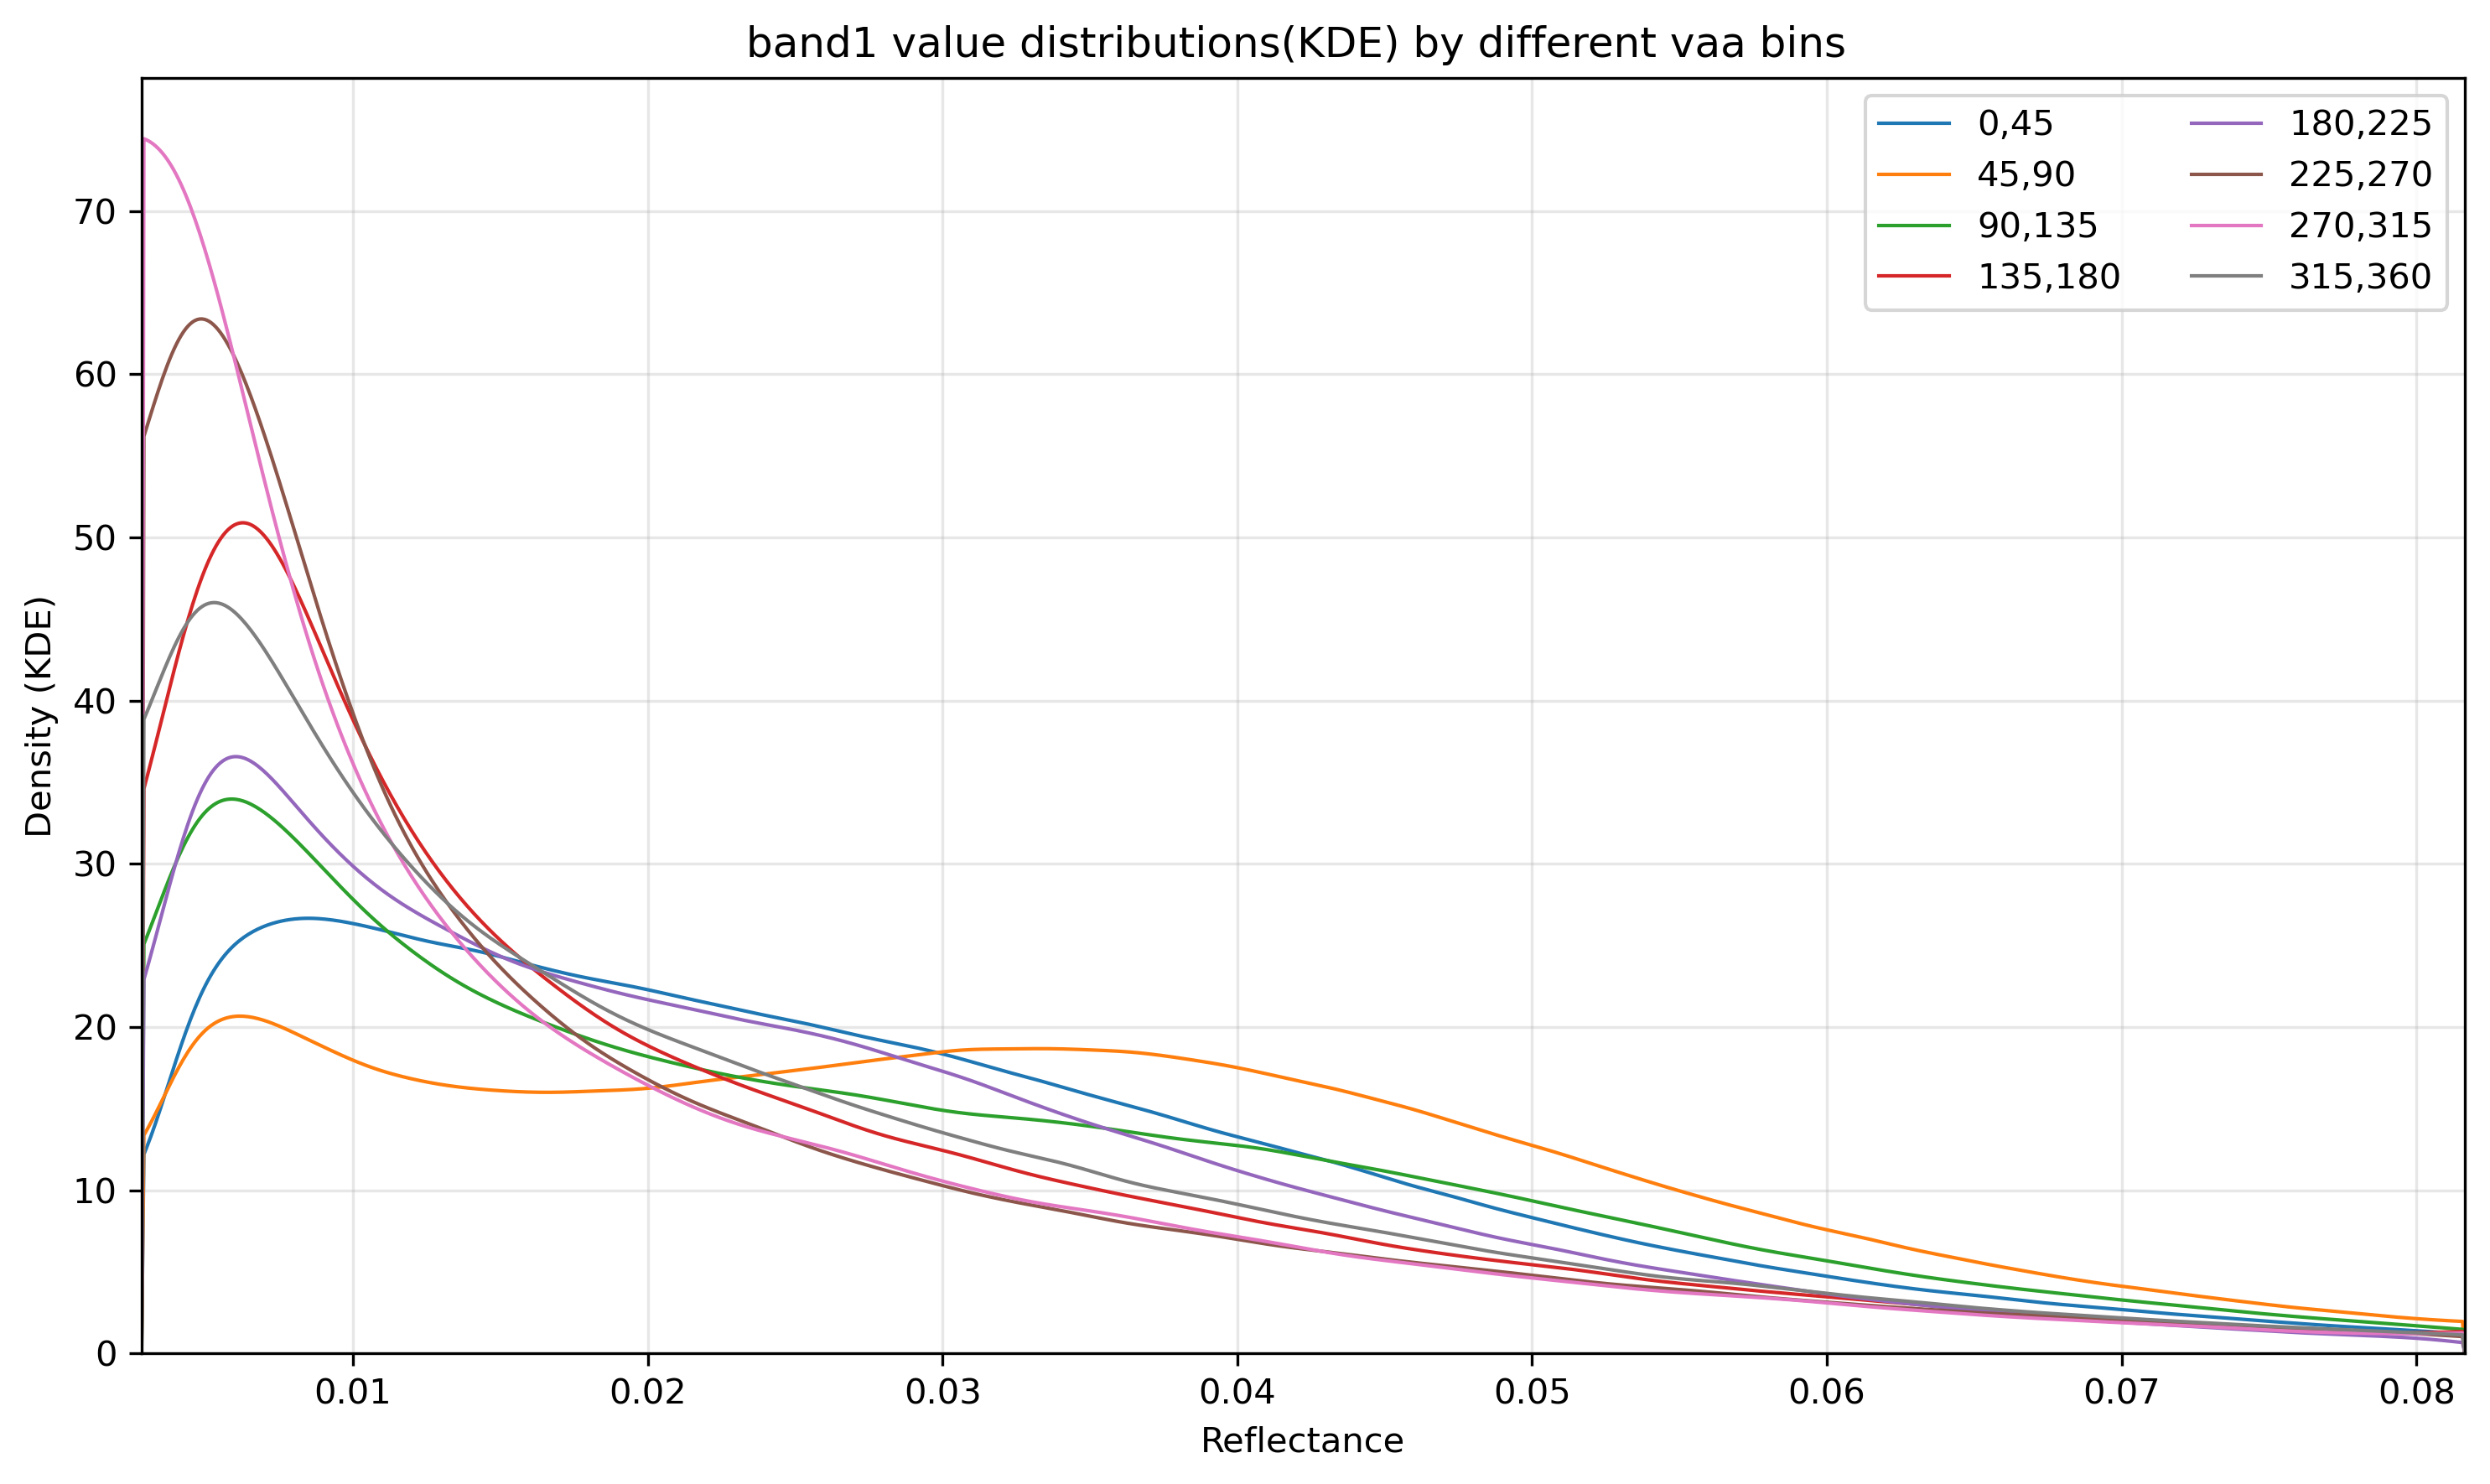

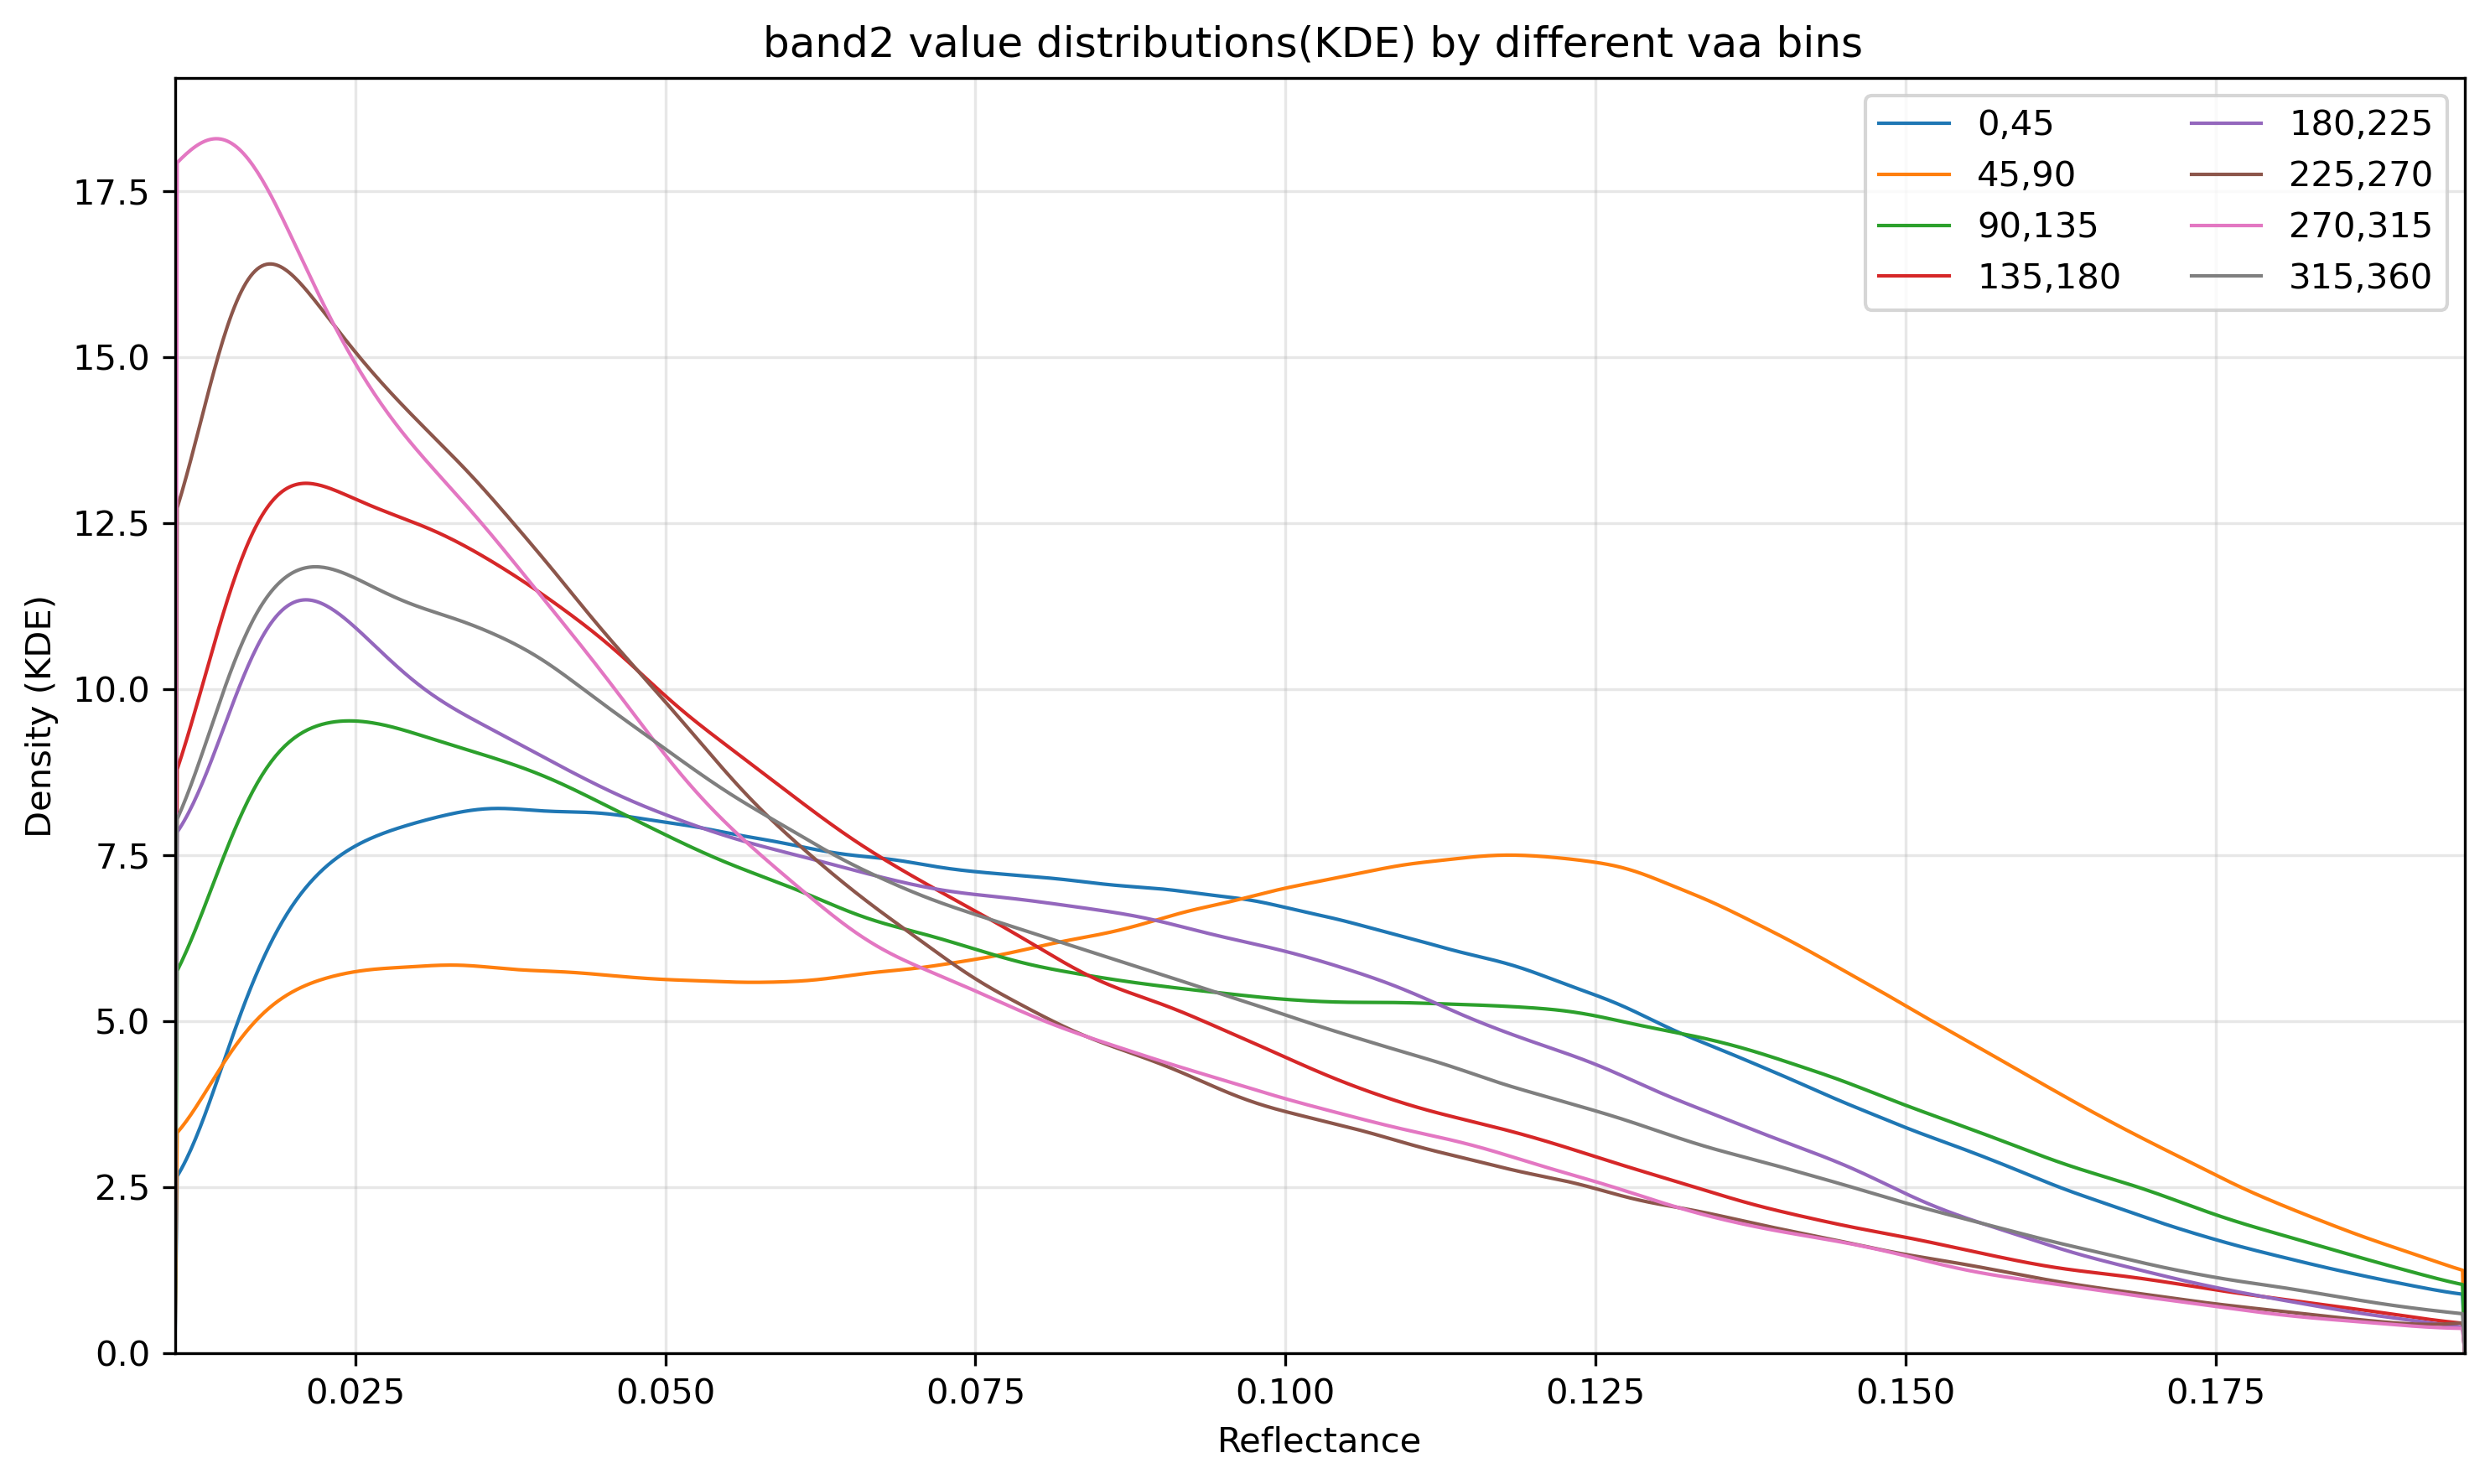

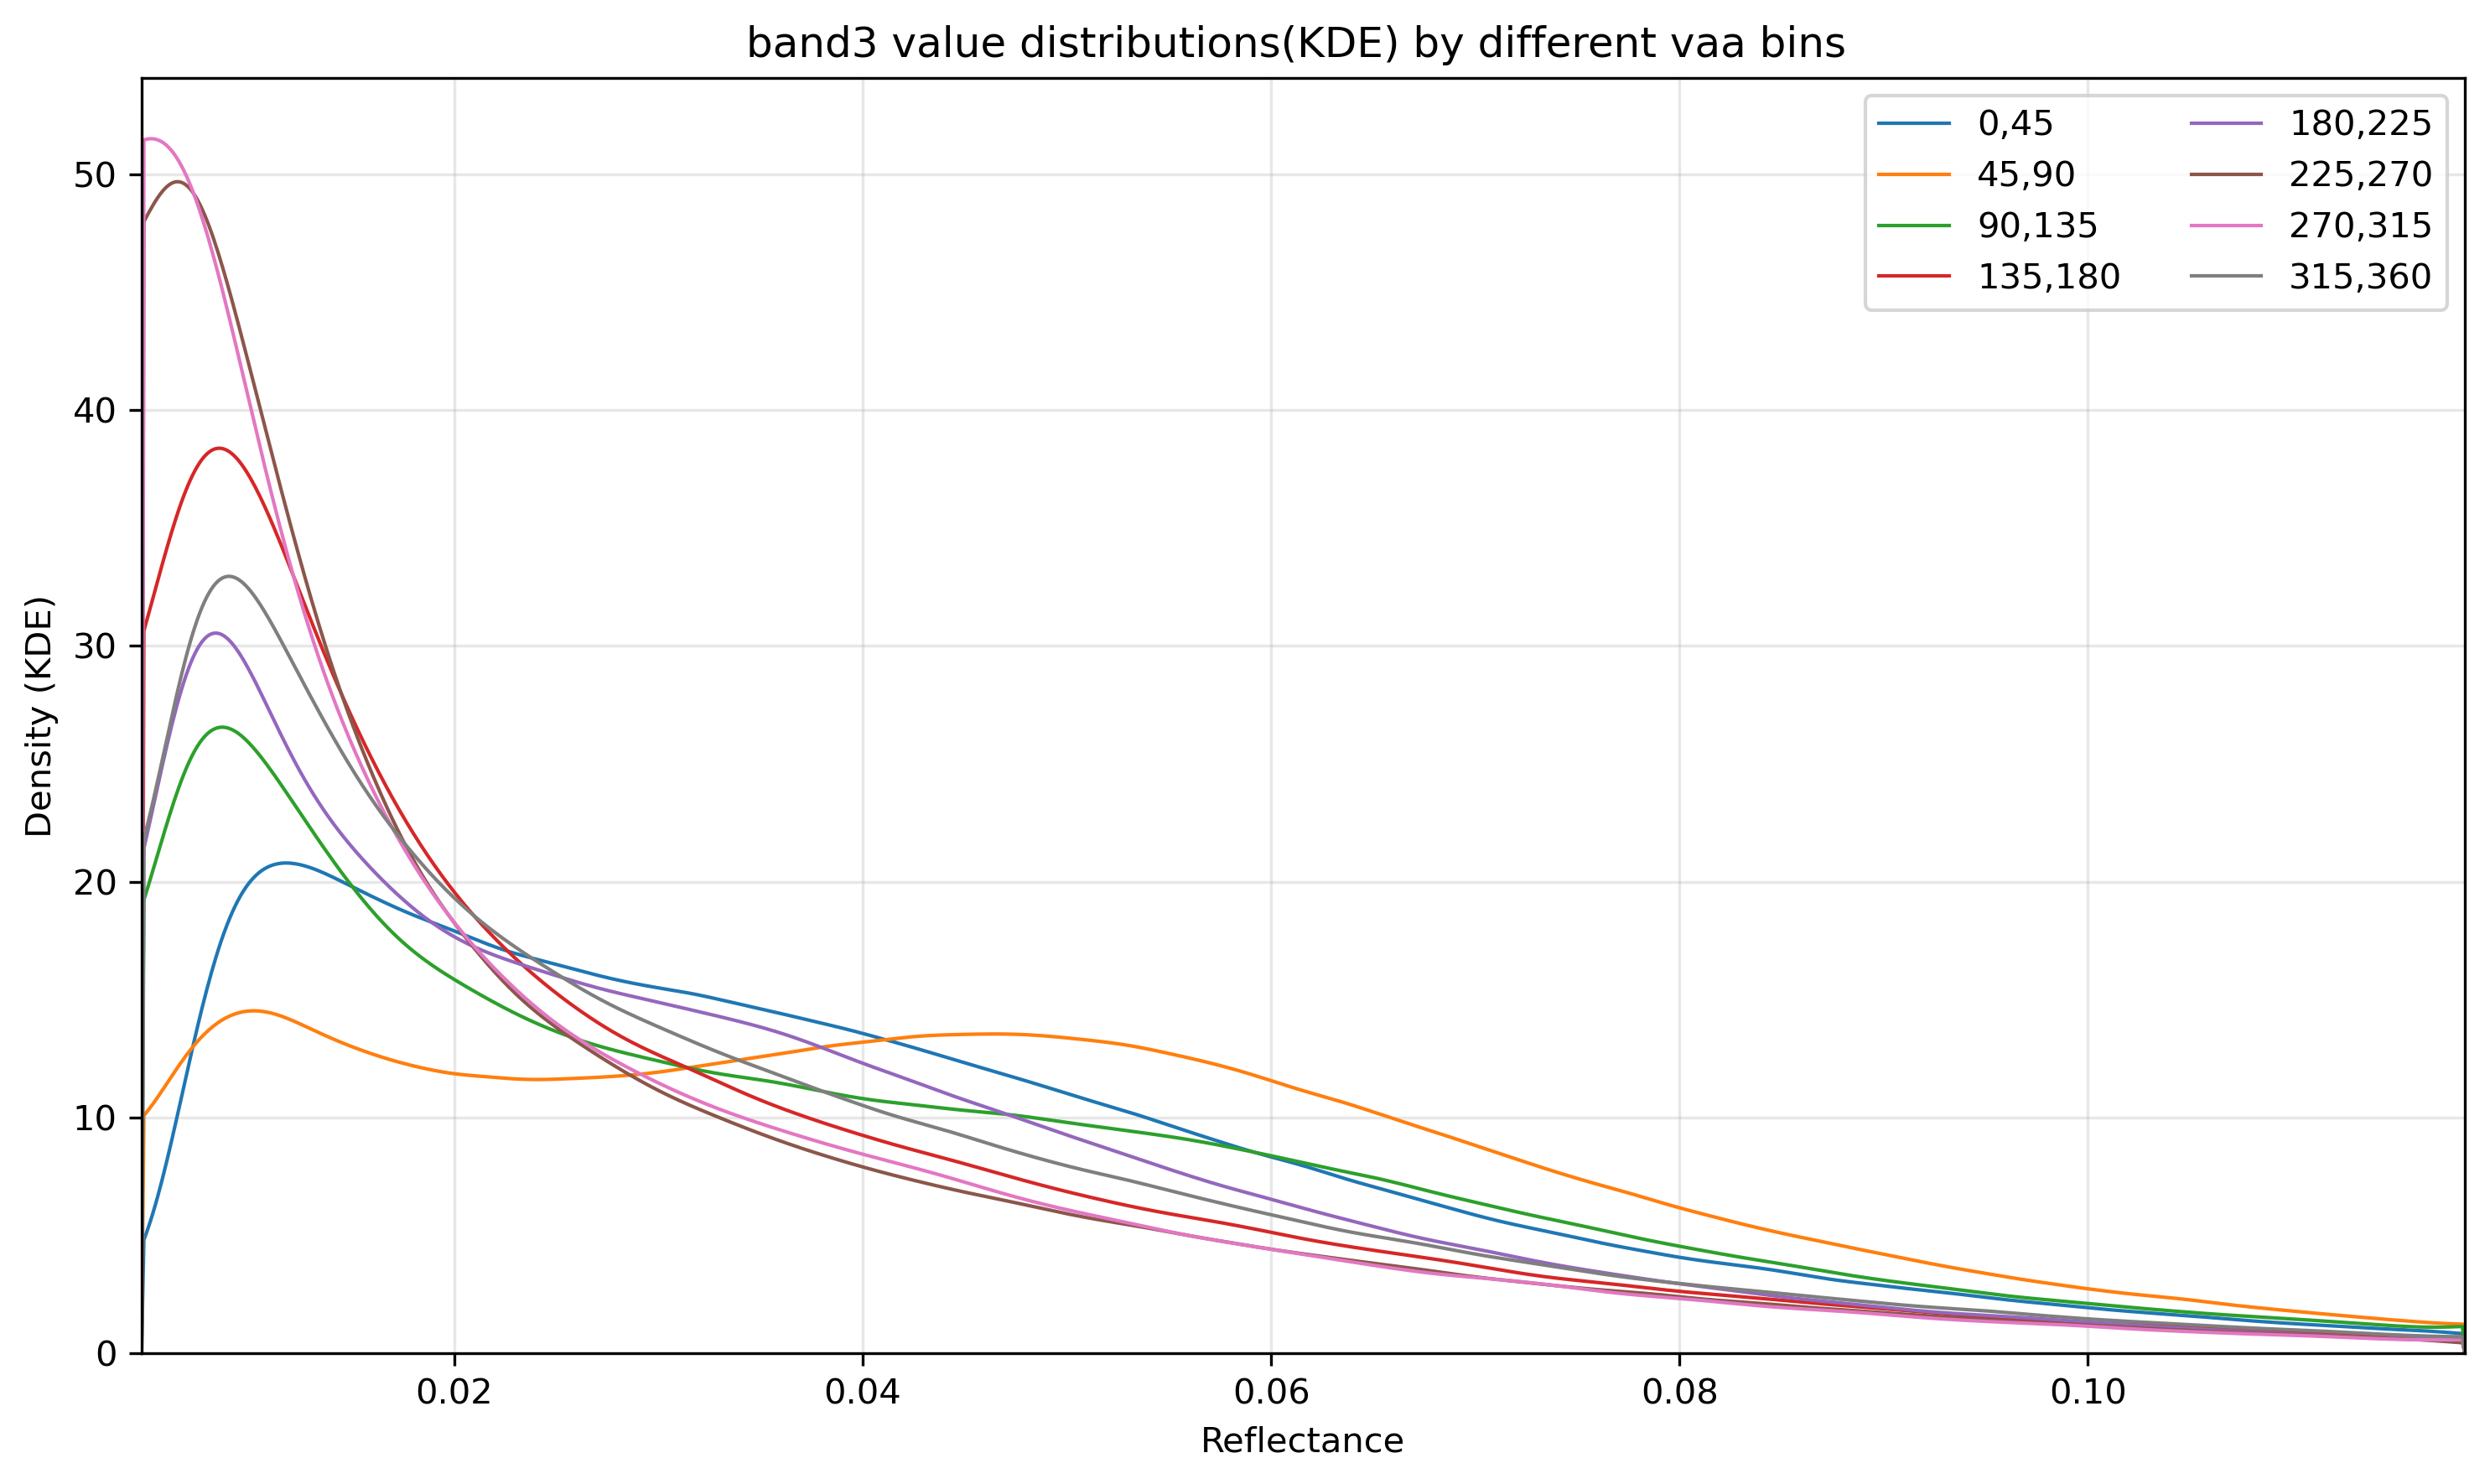

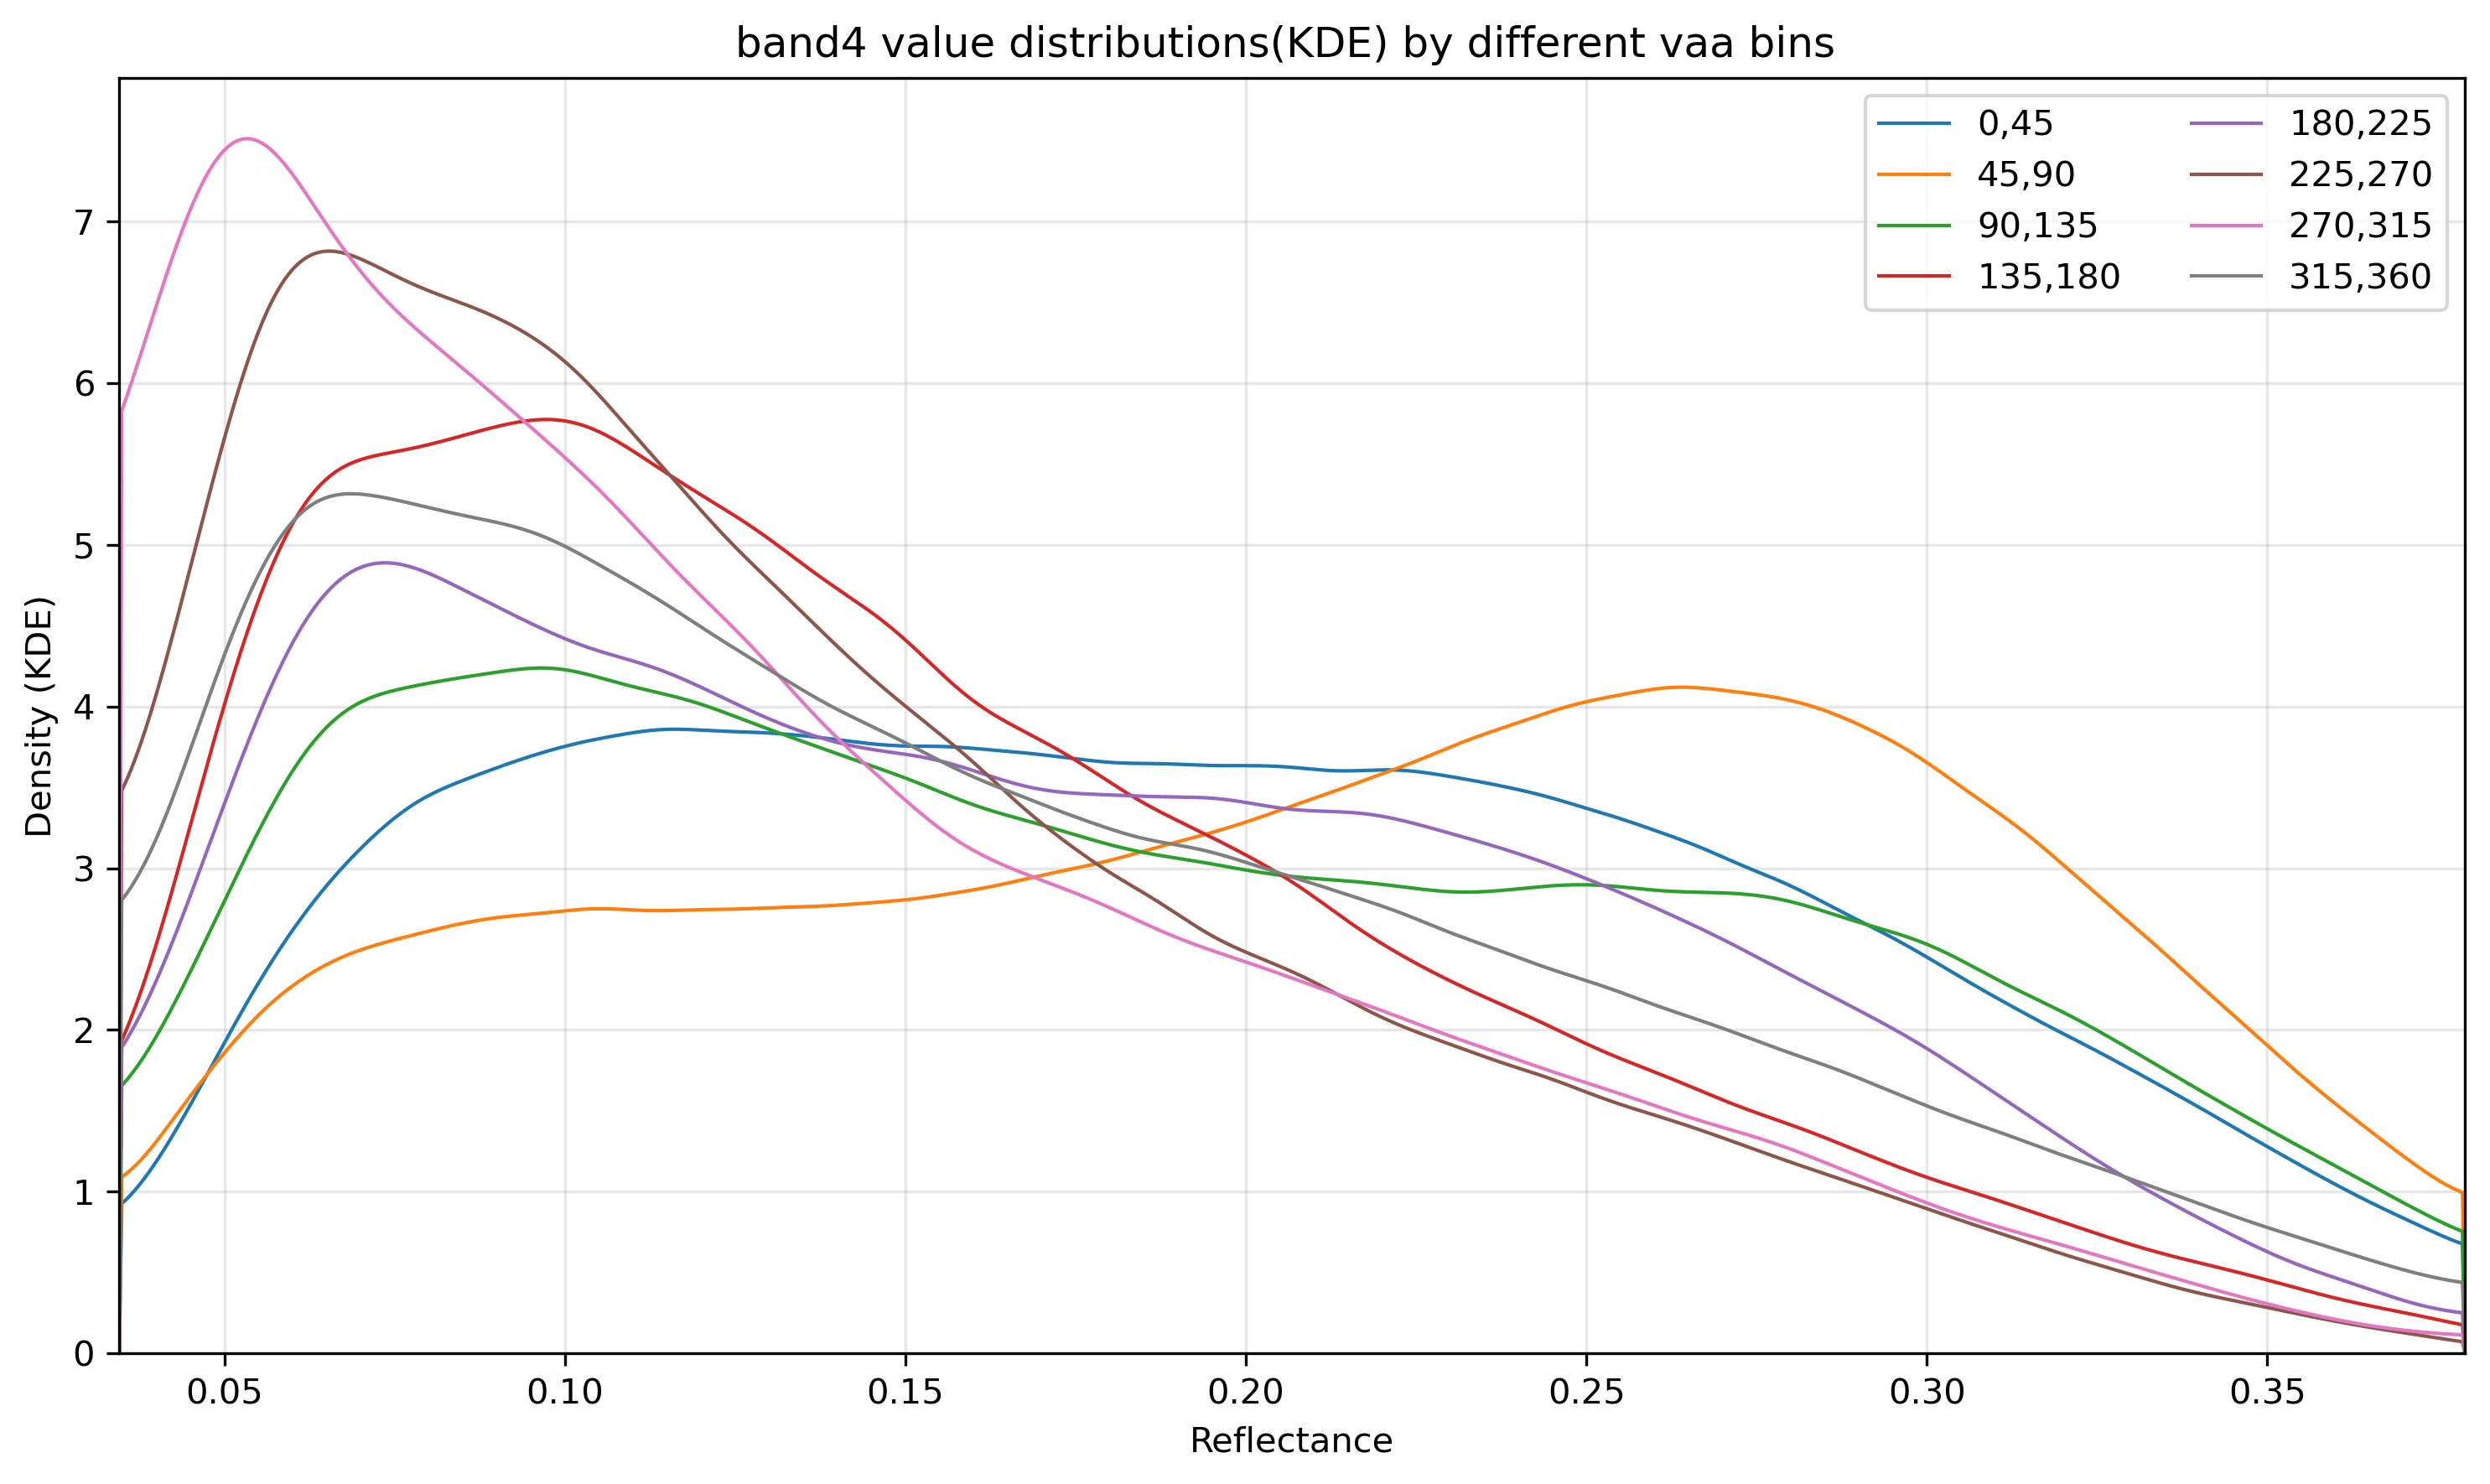

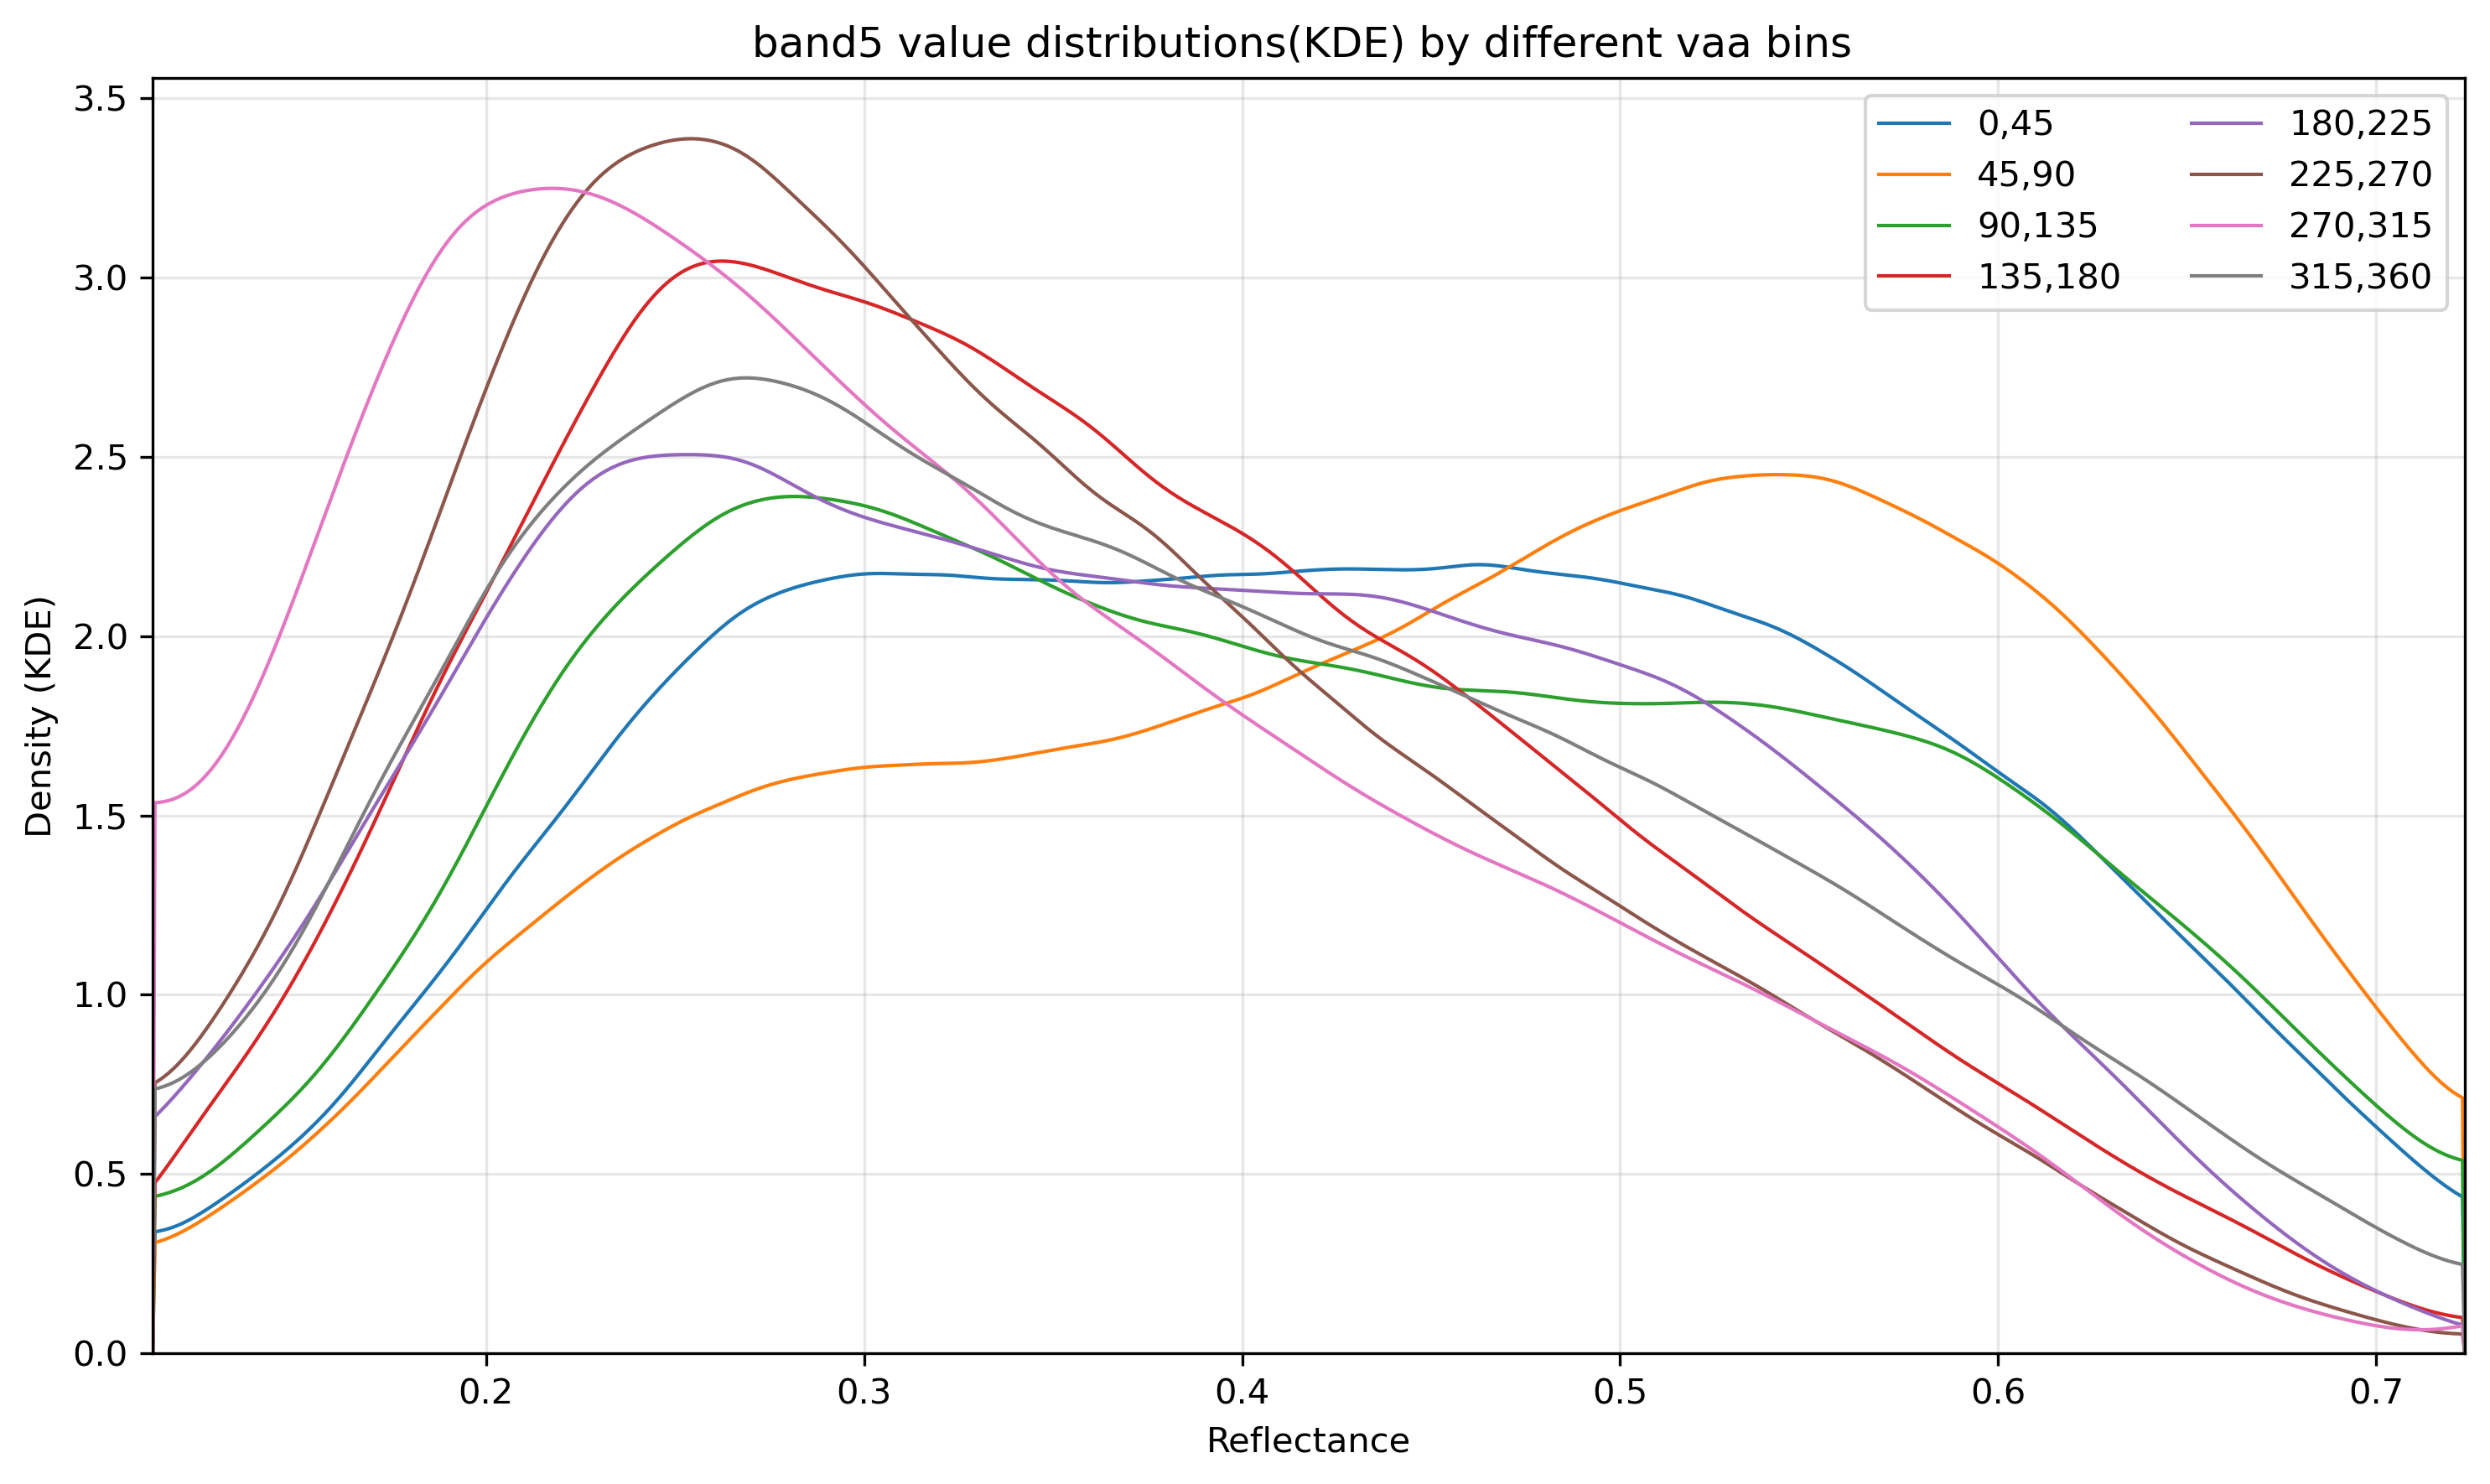

In [5]:
vaa_bins = [(i-45, i) for i in   range(45,361,45)]
print(vaa_bins)
for band in [f"band{i}" for i in range(1,6)]:
    angle_kde_plot(dataframe, band=band, bins=vaa_bins, points=1000, linewidth=1, colors=None, dpi=300, xlim=None, angle='vaa')

In [6]:
def assign_bin(v):
    for lo, hi in vaa_bins:
        if lo <= v < hi:
            return f"{lo}-{hi}"   # hashable
    return None

dataframe = dataframe.with_columns(
    pl.col("vaa").map_elements(assign_bin, return_dtype=pl.Utf8).alias("vaa_bin")
).drop_nulls("vaa_bin")


def assign_bin(v):
    for lo, hi in vza_bins:
        if lo <= v < hi:
            return f"{lo}-{hi}"
    return None

dataframe = dataframe.with_columns(
    pl.col("vza").map_elements(assign_bin, return_dtype=pl.Utf8).alias("vza_bin")
).drop_nulls("vza_bin")

print(dataframe)

shape: (19_258_665, 25)
┌──────────────┬──────────┬──────────┬──────────┬───┬────────────┬─────────────┬─────────┬─────────┐
│ Xw           ┆ Yw       ┆ band1    ┆ band2    ┆ … ┆ saa        ┆ path        ┆ vaa_bin ┆ vza_bin │
│ ---          ┆ ---      ┆ ---      ┆ ---      ┆   ┆ ---        ┆ ---         ┆ ---     ┆ ---     │
│ f64          ┆ f64      ┆ f32      ┆ f32      ┆   ┆ f32        ┆ str         ┆ str     ┆ str     │
╞══════════════╪══════════╪══════════╪══════════╪═══╪════════════╪═════════════╪═════════╪═════════╡
│ 563626.10476 ┆ 5.7130e6 ┆ 0.015855 ┆ 0.045515 ┆ … ┆ 181.269867 ┆ IMG_0197_6. ┆ 90-135  ┆ 30-45   │
│ 7            ┆          ┆          ┆          ┆   ┆            ┆ tif         ┆         ┆         │
│ 563626.11201 ┆ 5.7130e6 ┆ 0.021579 ┆ 0.063627 ┆ … ┆ 181.269867 ┆ IMG_0197_6. ┆ 90-135  ┆ 30-45   │
│ 9            ┆          ┆          ┆          ┆   ┆            ┆ tif         ┆         ┆         │
│ 563626.11927 ┆ 5.7130e6 ┆ 0.029257 ┆ 0.089474 ┆ … ┆ 181.269867 ┆ 

In [7]:
import polars as pl
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import f as f_dist, studentized_range
import time
import numpy as np
import polars as pl
import itertools




def descriptive_statistics(dataframe, band_col, angle_col):
    df = dataframe.select([angle_col, band_col]).drop_nulls().filter(pl.col(band_col).is_finite())

    group_summary = (
        df.group_by(angle_col)
           .agg([
               pl.len().alias("n"),
               pl.col(band_col).mean().alias("mean"),
               pl.col(band_col).std().alias("sd"),
               pl.col(band_col).median().alias("median"),
               pl.col(band_col).quantile(0.90).alias("q90"),
               pl.col(band_col).quantile(0.99).alias("q99"),
           ])
           .with_columns([
               (pl.col("sd")/pl.col("n").cast(pl.Float64).sqrt()).alias("se"),
               (pl.col("mean")-1.96*pl.col("sd")/pl.col("n").cast(pl.Float64).sqrt()).alias("ci_lo"),
               (pl.col("mean")+1.96*pl.col("sd")/pl.col("n").cast(pl.Float64).sqrt()).alias("ci_hi"),
           ])
           .sort("mean", descending=True)
    )

    return group_summary

def ANOVA(dataframe, band_col):

    ## ANOVA MAIN
    dfc = (dataframe.select(["vza_bin", band_col]).drop_nulls().filter(pl.col(band_col).is_finite()))



    # Set up multiple comparison analysis using Tukey's HSD test
    # MultiComparison requires the dependent variable (band1) and grouping variable (vza_bin)
    tk = pairwise_tukeyhsd(dfc[band_col].to_numpy(), dfc["vza_bin"].to_numpy())
    rows = tk.summary().data[1:]  # trusted order: group1, group2, meandiff, p-adj, lower, upper, reject



    # Generate all possible pairwise combinations of groups for comparison
    # This creates tuples like (group1, group2), (group1, group3), etc.
    # per-bin vectors for effect sizes
    grp = {g: dfc.filter(pl.col("vza_bin") == g)[band_col].to_numpy() for g in tk.groupsunique}



    # Define function to calculate Cohen's d (effect size measure)
    # Cohen's d = (mean1 - mean2) / pooled_standard_deviation
    def cd(a, b):
        n1, n2 = len(a), len(b)  # Sample sizes for each group
        s1 = np.var(a, ddof=1)   # Variance of group 1 (sample variance)
        s2 = np.var(b, ddof=1)   # Variance of group 2 (sample variance)

        # Calculate pooled standard deviation
        sp = np.sqrt(((n1-1)*s1 + (n2-1)*s2) / (n1+n2-2))

        # Return Cohen's d: difference in means divided by pooled standard deviation
        return (np.mean(a) - np.mean(b)) / sp

    # Calculate Cohen's d for all pairwise comparisons
    g1 = [r[0] for r in rows]
    g2 = [r[1] for r in rows]
    meandiff = np.array([r[2] for r in rows], float)
    p = np.array([r[3] for r in rows], float)
    lower = np.array([r[4] for r in rows], float)
    upper = np.array([r[5] for r in rows], float)
    reject = np.array([r[6] for r in rows], bool)
    d = [abs(cd(grp[a], grp[b])) for a, b in zip(g1, g2)]
    tiny = np.nextafter(0, 1); nlog10 = -np.log10(np.clip(p, tiny, 1.0))
    ptxt = [("p < 0.0001" if (x == 0 or x < 1e-300) else f"{x:.3e}") for x in p]



    #F statistic
    groups = [grp[g] for g in tk.groupsunique]
    ns     = [len(a) for a in groups]
    means  = [a.mean() for a in groups]
    N, k   = sum(ns), len(groups)
    grand  = sum(n*m for n, m in zip(ns, means)) / N
    SSB    = sum(n * (m - grand)**2 for n, m in zip(ns, means))
    SSW    = sum(((a - m)**2).sum() for a, m in zip(groups, means))
    dfn, dfd = k - 1, N - k
    MSB, MSW = SSB / dfn, SSW / dfd
    F = MSB / MSW
    p_global = f_dist.sf(F, dfn, dfd)
    neglog10p = -np.log10(np.clip(p_global, np.nextafter(0,1), 1.0))
    eta_sq = SSB / (SSB + SSW)



    # Create comprehensive results table with all statistical measures
    tbl = pl.DataFrame({
        "group1": g1,        # First group in each comparison
        "group2": g2,        # Second group in each comparison
        "mean group 2 - group1": meandiff,               # Mean difference between group2 - group1
        "CI+-": upper - lower,              # Lower confidence interval bound
        "p_text": ptxt,                         # Formatted p-values for display
        "-log10_p": nlog10,                     # Negative log10 p-values (significance strength)
        "cohens_d":d,                          # Effect size (Cohen's d)
        "reject": reject                     # Boolean: reject null hypothesis?
    }).with_columns(
        pl.col("-log10_p").round(3),           # Round -log10 p-values to 3 decimals
        pl.col("cohens_d").round(3),           # per-pair standardized effect size |mean1-mean2|/spooled
        pl.lit(F).alias("F_global"),           # one-way ANOVA F-statistic across vza_bin for THIS band
        pl.lit(dfn/dfd).round(10).alias("degrees of freedom"),       # degrees of freedom: numerator df = k - 1 (k = number of bins)  /
                                                                     # denominator df = N - k (N = total observations)
        pl.lit(eta_sq).round(3).alias("eta_sq")                      # effect size: SSB / (SSB + SSW), variance explained by vza_bin
    )

    tbl.sort("cohens_d",descending=True)


    return tbl

def ANOVA_optimized(dataframe, band_col, col=None):
    """
    Optimized ANOVA implementation with custom Tukey's HSD for large datasets.
    Uses Polars and NumPy for efficient computation of statistics.

    Args:
        dataframe: A Polars DataFrame
        band_col: Column name containing the dependent variable
    """

    # Start with lazy operations to optimize memory usage
    # Select only necessary columns, remove nulls and non-finite values
    lazy_df = dataframe.lazy().select([col, band_col]).drop_nulls().filter(pl.col(band_col).is_finite())

    # Calculate all group statistics in a single efficient pass
    # This avoids multiple passes through the data for each statistic
    group_stats = (lazy_df.group_by(col)
                     .agg([
                         pl.col(band_col).count().alias("n"),              # Sample size per group
                         pl.col(band_col).mean().alias("mean"),            # Group means
                         pl.col(band_col).var().alias("var"),              # Group variances
                         pl.col(band_col).sum().alias("sum")               # Group sums (for calculations)
                     ])
                     .collect())  # Execute the lazy computation

    # Extract statistics for calculations
    groups = group_stats[col].to_numpy()
    ns = group_stats["n"].to_numpy()
    means = group_stats["mean"].to_numpy()
    variances = group_stats["var"].to_numpy()

    # Calculate ANOVA statistics
    N = sum(ns)                                   # Total sample size
    k = len(groups)                               # Number of groups
    grand_mean = sum(n*m for n, m in zip(ns, means)) / N  # Overall mean

    # Between-group sum of squares (variation explained by group differences)
    SSB = sum(n * (m - grand_mean)**2 for n, m in zip(ns, means))

    # Within-group sum of squares (variation not explained by groups)
    SSW = sum((n-1) * v for n, v in zip(ns, variances))

    # Calculate F-statistic and p-value
    dfn, dfd = k - 1, N - k                       # Degrees of freedom (between and within groups)
    MSB, MSW = SSB / dfn, SSW / dfd               # Mean squares (between and within)
    F = MSB / MSW                                 # F statistic (ratio of between to within variation)
    p_global = f_dist.sf(F, dfn, dfd)             # Global p-value for ANOVA
    eta_sq = SSB / (SSB + SSW)                    # Effect size (proportion of variance explained)

    # Collect full dataset for pairwise comparisons
    dfc = lazy_df.collect()

    # Generate all unique pairs of groups for comparison
    # This creates tuples like (group1, group2), (group1, group3), etc.
    pairs = list(itertools.combinations(groups, 2))

    # Pre-compute statistics for each group once to avoid repeated calculations
    # This is more efficient than extracting the data repeatedly
    group_data = {}
    for g in groups:
        group_data[g] = {
            'mean': dfc.filter(pl.col(col) == g)[band_col].mean(),
            'n': dfc.filter(pl.col(col) == g).height,
            'var': dfc.filter(pl.col(col) == g)[band_col].var()
        }

    # Custom implementation of Tukey's HSD test
    # This avoids the slower implementation in statsmodels
    results = []
    for g1, g2 in pairs:
        # Extract pre-computed statistics for the pair
        mean1 = group_data[g1]['mean']
        mean2 = group_data[g2]['mean']
        n1 = group_data[g1]['n']
        n2 = group_data[g2]['n']
        var1 = group_data[g1]['var']
        var2 = group_data[g2]['var']

        # Calculate mean difference between groups
        meandiff = mean2 - mean1

        # Calculate pooled standard error for Tukey's HSD
        se = np.sqrt(MSW * (1/n1 + 1/n2))

        # Calculate q statistic for Tukey's HSD
        q = abs(meandiff) / se

        # Calculate critical q value for confidence intervals
        q_crit = studentized_range.ppf(0.99, k, dfd)

        # Calculate confidence interval bounds
        lower = meandiff - q_crit * se
        upper = meandiff + q_crit * se

        # Calculate adjusted p-value for the comparison
        p = studentized_range.sf(q, k, dfd)

        # Calculate Cohen's d effect size (standardized mean difference)
        # Pooled standard deviation using weighted average of group variances
        sp = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
        cohens_d = abs(mean1 - mean2) / sp

        # Determine if null hypothesis is rejected (alpha = 0.005)
        reject = (p < 0.005)

        # Store results for this pair
        results.append({
            'group1': g1,
            'group2': g2,
            'meandiff': meandiff,
            'lower': lower,
            'upper': upper,
            'p_adj': p,
            'cohens_d': cohens_d,
            'reject': reject
        })

    # Format results for output DataFrame
    g1 = [r['group1'] for r in results]
    g2 = [r['group2'] for r in results]
    meandiff = [r['meandiff'] for r in results]
    p = [r['p_adj'] for r in results]
    lower = [r['lower'] for r in results]
    upper = [r['upper'] for r in results]
    cohens_d = [r['cohens_d'] for r in results]
    reject = [r['reject'] for r in results]

    # Process significance levels for display
    tiny = np.nextafter(0, 1)  # Smallest positive float for handling very small p-values
    nlog10 = -np.log10(np.clip(p, tiny, 1.0))  # Negative log10 of p-values (higher = more significant)
    ptxt = [("p < 0.0001" if (x == 0 or x < 1e-4) else f"{x:.3e}") for x in p]  # Formatted p-values

    # Calculate confidence interval range
    CI_range = [u - l for u, l in zip(upper, lower)]

    # Create comprehensive results table with all statistical measures
    tbl = pl.DataFrame({
        "group1": g1,                        # First group in each comparison
        "group2": g2,                        # Second group in each comparison
        "mean group 2 - group1": meandiff,   # Mean difference between group2 - group1
        "CI+-": CI_range,                    # Confidence interval range
        "p_text": ptxt,                      # Formatted p-values for display
        "-log10_p": nlog10,                  # Negative log10 p-values (significance strength)
        "cohens_d": cohens_d,                # Effect size (Cohen's d)
        "reject": reject                     # Boolean: reject null hypothesis?
    }).with_columns([
        pl.col("-log10_p").round(3),         # Round -log10 p-values to 3 decimals
        pl.col("cohens_d").round(3),         # Round Cohen's d to 3 decimals
        pl.lit(F).alias("F_global"),         # One-way ANOVA F-statistic across vza_bin for this band
        pl.lit(dfn/dfd).round(10).alias("degrees of freedom"),  # Degrees of freedom ratio
        pl.lit(eta_sq).round(3).alias("eta_sq")  # Effect size: variance explained by vza_bin
    ])

    # Sort by effect size (largest effects first)
    result = tbl.sort("cohens_d", descending=True)

    return result


In [8]:
descriptive_statistics(dataframe=dataframe, band_col="band5", angle_col = "vaa_bin")


shape: (8, 10)
┌─────────┬─────────┬──────────┬──────────┬───┬──────────┬──────────┬──────────┬──────────┐
│ vaa_bin ┆ n       ┆ mean     ┆ sd       ┆ … ┆ q99      ┆ se       ┆ ci_lo    ┆ ci_hi    │
│ ---     ┆ ---     ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ str     ┆ u32     ┆ f32      ┆ f32      ┆   ┆ f32      ┆ f64      ┆ f64      ┆ f64      │
╞═════════╪═════════╪══════════╪══════════╪═══╪══════════╪══════════╪══════════╪══════════╡
│ 45-90   ┆ 5685781 ┆ 0.455365 ┆ 0.159743 ┆ … ┆ 0.765748 ┆ 0.000067 ┆ 0.455234 ┆ 0.455497 │
│ 0-45    ┆ 3282497 ┆ 0.422068 ┆ 0.152721 ┆ … ┆ 0.747194 ┆ 0.000084 ┆ 0.421903 ┆ 0.422233 │
│ 90-135  ┆ 1217274 ┆ 0.412114 ┆ 0.161076 ┆ … ┆ 0.760818 ┆ 0.000146 ┆ 0.411828 ┆ 0.4124   │
│ 180-225 ┆ 542925  ┆ 0.368443 ┆ 0.145726 ┆ … ┆ 0.677105 ┆ 0.000198 ┆ 0.368056 ┆ 0.368831 │
│ 315-360 ┆ 1071802 ┆ 0.366264 ┆ 0.151102 ┆ … ┆ 0.718124 ┆ 0.000146 ┆ 0.365978 ┆ 0.36655  │
│ 135-180 ┆ 373749  ┆ 0.352832 ┆ 0.135127 ┆ … ┆ 0.678639 ┆ 0.000221 ┆ 0.352399 ┆ 0.353265 │
│ 225-270 ┆ 801302  ┆ 0.329424 ┆ 0.131851 ┆ … ┆ 0.655475 ┆ 0.000147 ┆ 0.329135 ┆ 0.329712 │
│ 270-315 ┆ 157593  ┆ 0.312601 ┆ 0.137292 ┆ … ┆ 0.64449  ┆ 0.000346 ┆ 0.311924 ┆ 0.313279 │
└─────────┴─────────┴──────────┴──────────┴───┴──────────┴──────────┴──────────┴──────────┘

In [9]:

ANOVA_optimized(dataframe=dataframe.sample(500000), band_col="band5", col = "vaa_bin")

shape: (28, 11)
┌─────────┬─────────┬──────────────────┬──────────┬───┬────────┬─────────────┬────────────┬────────┐
│ group1  ┆ group2  ┆ mean group 2 -   ┆ CI+-     ┆ … ┆ reject ┆ F_global    ┆ degrees of ┆ eta_sq │
│ ---     ┆ ---     ┆ group1           ┆ ---      ┆   ┆ ---    ┆ ---         ┆ freedom    ┆ ---    │
│ str     ┆ str     ┆ ---              ┆ f64      ┆   ┆ bool   ┆ f64         ┆ ---        ┆ f64    │
│         ┆         ┆ f64              ┆          ┆   ┆        ┆             ┆ f64        ┆        │
╞═════════╪═════════╪══════════════════╪══════════╪═══╪════════╪═════════════╪════════════╪════════╡
│ 45-90   ┆ 270-315 ┆ -0.142367        ┆ 0.024361 ┆ … ┆ true   ┆ 3406.629436 ┆ 0.000021   ┆ 0.065  │
│ 45-90   ┆ 225-270 ┆ -0.125359        ┆ 0.011361 ┆ … ┆ true   ┆ 3406.629436 ┆ 0.000021   ┆ 0.065  │
│ 0-45    ┆ 270-315 ┆ -0.108953        ┆ 0.024599 ┆ … ┆ true   ┆ 3406.629436 ┆ 0.000021   ┆ 0.065  │
│ 45-90   ┆ 135-180 ┆ -0.102756        ┆ 0.016121 ┆ … ┆ true   ┆ 3406.629436 ┆ 0.000021   ┆ 0.065  │
│ 90-135  ┆ 270-315 ┆ -0.099285        ┆ 0.025552 ┆ … ┆ true   ┆ 3406.629436 ┆ 0.000021   ┆ 0.065  │
│ …       ┆ …       ┆ …                ┆ …        ┆ … ┆ …      ┆ …           ┆ …          ┆ …      │
│ 270-315 ┆ 225-270 ┆ 0.017008         ┆ 0.026272 ┆ … ┆ true   ┆ 3406.629436 ┆ 0.000021   ┆ 0.065  │
│ 180-225 ┆ 135-180 ┆ -0.015905        ┆ 0.020273 ┆ … ┆ true   ┆ 3406.629436 ┆ 0.000021   ┆ 0.065  │
│ 135-180 ┆ 315-360 ┆ 0.012366         ┆ 0.018156 ┆ … ┆ true   ┆ 3406.629436 ┆ 0.000021   ┆ 0.065  │
│ 0-45    ┆ 90-135  ┆ -0.009668        ┆ 0.01017  ┆ … ┆ true   ┆ 3406.629436 ┆ 0.000021   ┆ 0.065  │
│ 180-225 ┆ 315-360 ┆ -0.003539        ┆ 0.015909 ┆ … ┆ false  ┆ 3406.629436 ┆ 0.000021   ┆ 0.065  │
└─────────┴─────────┴──────────────────┴──────────┴───┴────────┴─────────────┴────────────┴────────┘

In [13]:
import polars as pl
import numpy as np
from scipy.stats import ttest_ind, spearmanr
from scipy.stats import t as t_dist
import matplotlib.pyplot as plt
from tabulate import tabulate  # For pretty printing tables

def calculate_geometry(dataframe):
    """
    Calculate angular geometry parameters from solar/viewing angles.

    Parameters:
        dataframe: Polars DataFrame with sunelev, saa, vaa columns

    Returns:
        Polars DataFrame with added phase angle and RAA columns
    """
    rad = np.pi / 180  # Conversion factor from degrees to radians

    return (
        dataframe.lazy()
        # Convert sun elevation to zenith angle
        .with_columns((90 - pl.col("sunelev")).alias("sza"))
        # Calculate relative azimuth angle constrained to [0,180]
        .with_columns(
            pl.min_horizontal(
                (pl.col("saa") - pl.col("vaa")).abs(),
                360 - (pl.col("saa") - pl.col("vaa")).abs(),
            ).alias("RAA")
        )
        # Calculate phase angle (degrees) using the law of cosines for spherical triangles
        .with_columns(
            (
                (
                    (pl.col("sza") * rad).cos() * (pl.col("vza") * rad).cos() +
                    (pl.col("sza") * rad).sin() * (pl.col("vza") * rad).sin() *
                    (pl.col("RAA") * rad).cos()
                )
                .clip(-1.0, 1.0)  # Prevent numerical errors in arccos
                .arccos() / rad
            ).alias("phase")
        )
        .select(["phase", "RAA", "band5"])
        .collect(streaming=True)
    )

def calculate_hot_spot_index(df, g0=5, ref_range=(20, 30), band="band5", raa_max=10):
    """
    Calculate the Hot Spot Index (HSI) and related statistics.

    Parameters:
        df: Polars DataFrame with phase, RAA, and band columns
        g0: Maximum phase angle for hot spot region (degrees)
        ref_range: Tuple with min and max phase angles for reference region (degrees)
        band: Column name for the spectral band to analyze
        raa_max: Maximum relative azimuth angle to include (backscatter plane)

    Returns:
        Dict with HSI metrics and statistical test results
    """
    # Filter to just backscatter plane (low RAA)
    backscatter_df = df.filter(pl.col("RAA") <= raa_max)

    # Extract hot spot region (phase <= g0)
    hotspot_samples = backscatter_df.filter(pl.col("phase") <= g0)[band].to_numpy()

    # Extract reference region (ref_range[0] <= phase <= ref_range[1])
    ref_min, ref_max = ref_range
    reference_samples = backscatter_df.filter(
        (pl.col("phase") >= ref_min) &
        (pl.col("phase") <= ref_max)
    )[band].to_numpy()

    # Calculate Hot Spot Index (difference between means)
    hsi_value = float(hotspot_samples.mean() - reference_samples.mean())

    # Welch's t-test (unequal variances)
    t_statistic, p_value = ttest_ind(hotspot_samples, reference_samples, equal_var=False)

    # Calculate additional statistics for the HSI
    stats = calculate_effect_size(hotspot_samples, reference_samples)

    # Spearman correlation for forward scattering trend (phase <= 30°)
    forward_df = backscatter_df.filter(pl.col("phase") <= 30)
    rho, p_rho = spearmanr(forward_df["phase"].to_numpy(), forward_df[band].to_numpy())

    # Compile results
    results = {
        "HSI": hsi_value,
        "Welch_t": float(t_statistic),
        "p_value": float(p_value),
        "Spearman_rho": float(rho),
        "p_rho": float(p_rho),
        "n_hotspot": len(hotspot_samples),
        "n_reference": len(reference_samples),
        "CI95": stats["CI95"],
        "cohens_d": stats["cohens_d"],
        "rel_change": stats["rel_change"]
    }

    return results

def calculate_effect_size(a, b):
    """
    Calculate effect sizes and confidence intervals for the difference between means.

    Parameters:
        a: NumPy array with hot spot samples
        b: NumPy array with reference samples

    Returns:
        Dict with confidence intervals and effect sizes
    """
    # Calculate means and standard deviations
    m1, m2 = a.mean(), b.mean()
    s1, s2 = a.std(ddof=1), b.std(ddof=1)
    n1, n2 = len(a), len(b)

    # Mean difference
    delta = m1 - m2

    # Standard error (Welch's t-test)
    se = np.sqrt(s1*s1/n1 + s2*s2/n2)

    # Degrees of freedom (Welch-Satterthwaite equation)
    df = (s1*s1/n1 + s2*s2/n2)**2 / ((s1*s1/n1)**2/(n1-1) + (s2*s2/n2)**2/(n2-1))

    # Critical t-value for 95% confidence interval
    crit = t_dist.ppf(0.975, df)

    # 95% confidence interval
    ci = (delta - crit*se, delta + crit*se)

    # Pooled standard deviation for Cohen's d
    sp = np.sqrt(((n1-1)*s1*s1 + (n2-1)*s2*s2) / (n1+n2-2))

    # Cohen's d effect size
    d = delta / sp

    # Relative change
    rel = delta / m2

    return {
        "CI95": (float(ci[0]), float(ci[1])),
        "cohens_d": float(d),
        "rel_change": float(rel)
    }

def print_hsi_results(results):
    """
    Print formatted results of the HSI analysis.
    """
    print("\n" + "="*60)
    print("HOT SPOT INDEX (HSI) ANALYSIS RESULTS")
    print("="*60)

    # Main HSI metrics
    print("\nHOT SPOT INDEX METRICS:")
    print(f"HSI Value:                  {results['HSI']:.4f}")
    print(f"95% Confidence Interval:    ({results['CI95'][0]:.4f}, {results['CI95'][1]:.4f})")
    print(f"Relative Change:            {results['rel_change']:.2%}")

    # Effect size
    print("\nEFFECT SIZE:")
    print(f"Cohen's d:                  {results['cohens_d']:.4f}")

    # Statistical tests
    print("\nSTATISTICAL TESTS:")
    print(f"Welch's t-statistic:        {results['Welch_t']:.4f}")
    print(f"p-value (t-test):           {results['p_value']:.6f} " +
          ("(significant)" if results['p_value'] < 0.05 else "(not significant)"))
    print(f"Spearman's rho:             {results['Spearman_rho']:.4f}")
    print(f"p-value (Spearman):         {results['p_rho']:.6f} " +
          ("(significant)" if results['p_rho'] < 0.05 else "(not significant)"))

    # Sample sizes
    print("\nSAMPLE SIZES:")
    print(f"Hot spot samples (g ≤ 5°):  {results['n_hotspot']}")
    print(f"Reference samples (20-30°): {results['n_reference']}")
    print("="*60 + "\n")

def plot_hsi_results(df, results, g0=5, ref_range=(20, 30), band="band5", raa_max=10):
    """
    Create a visualization of the HSI analysis.
    """
    backscatter_df = df.filter(pl.col("RAA") <= raa_max)

    # Convert to pandas for easier plotting
    pdf = backscatter_df.to_pandas()

    plt.figure(figsize=(12, 6))

    # Scatter plot
    plt.scatter(pdf["phase"], pdf[band], alpha=0.3, color="gray", label="All measurements")

    # Highlight hot spot and reference regions
    hotspot = pdf[pdf["phase"] <= g0]
    reference = pdf[(pdf["phase"] >= ref_range[0]) & (pdf["phase"] <= ref_range[1])]

    plt.scatter(hotspot["phase"], hotspot[band], color="red", label=f"Hot spot (≤ {g0}°)")
    plt.scatter(reference["phase"], reference[band], color="blue", label=f"Reference ({ref_range[0]}-{ref_range[1]}°)")

    # Add mean lines
    plt.axhline(y=hotspot[band].mean(), color="red", linestyle="--", alpha=0.7)
    plt.axhline(y=reference[band].mean(), color="blue", linestyle="--", alpha=0.7)

    # Annotate HSI
    plt.annotate(f"HSI = {results['HSI']:.4f}",
                xy=(0.7, 0.9),
                xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc="lightyellow", ec="orange", alpha=0.8))

    plt.xlabel("Phase angle (degrees)")
    plt.ylabel(f"Reflectance ({band})")
    plt.title("Hot Spot Index Analysis")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()

    return plt

# Calculate geometry parameters
df = calculate_geometry(dataframe.drop_nans())

# Define HSI parameters
g0 = 5
ref_range = (20, 30)
band = "band5"
raa_max = 10

# Calculate HSI and related statistics
results = calculate_hot_spot_index(df, g0, ref_range, band, raa_max)

# Print formatted results
print_hsi_results(results)






HOT SPOT INDEX (HSI) ANALYSIS RESULTS

HOT SPOT INDEX METRICS:
HSI Value:                  0.0131
95% Confidence Interval:    (0.0101, 0.0161)
Relative Change:            3.84%

EFFECT SIZE:
Cohen's d:                  0.0923

STATISTICAL TESTS:
Welch's t-statistic:        8.6337
p-value (t-test):           0.000000 (significant)
Spearman's rho:             -0.0146
p-value (Spearman):         0.000000 (significant)

SAMPLE SIZES:
Hot spot samples (g ≤ 5°):  94626
Reference samples (20-30°): 9452



/tmp/ipykernel_44825/1722532301.py:44: DeprecationWarning: the `streaming` parameter was deprecated in 1.25.0; use `engine` instead.
  .collect(streaming=True)
